# Анализ А/В-теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы

## Ход исследования
>>
>> 1. [Загрузка данных:](#start)
>> * календарь маркетинговых событий на 2020 год из `'ab_project_marketing_events.csv '`
>> * пользователи, зарегистрировавшиеся с 7 до 21 декабря 2020 года из `'final_ab_new_users.csv '`
>> * действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года `'final_ab_events.csv'`
>> * таблица участников тестов из `'final_ab_participants.csv'`.
>>
>> 2. [Обзор и предобработка выгруженных данных. О качестве данных ничего неизвестно, поэтому перед тем как приступать к целям исследования, потребуется их обзор:](#preprocessing) <i> (проверим данные на пропуски и оценим их влияние на исследование. Осуществим проверку на явные дубликаты. Затем на этапе предобработки поищем возможность заполнить/удалить пропуски в данных, которые не приведут к искажению конечного результата. Преобразуем типы данных в колонках соответственно сохранённым в них значениям)</i>:
>> * [общая информация о датасетах](#all_information)
>> * [периоды, за которые представлены данные](#periods)
>> * [дополнительные данные о каждом из датасетов (уникальные события, уникальные группы, уникальные тесты, регионы, в которых зарегистрированы пользователи и т.д.)](#dop_info)
>>
>> 3. [Оценка корректности проведения теста](#verification)
>> * [в тест должно быть отобрано 15% новых пользователей из региона EU](#EU_users)
>> * [ожидаемое количество участников теста: 6000](#users_6000)
>> * [анализ пользователей не совершивших ни одного события](#no_events)
>> * [время проведения теста не совпадает с маркетинговыми активностями](#marketing)
>> * [лайфтайм: 14 дней с момента регистрации](#lifetime)
>> 
>> 4. [Промежуточные итоги](#pre_conclision)
>> 
>> 
>> 5. [Исследовательский анализ данных](#analysis)
>> * [проверка одинаково ли распределено количество событий на пользователя в выборках](#event_per_user)
>> * [анализ как число событий в выборках распределено по дням](#event_per_day)
>> * [анализ как меняется конверсия в воронке в выборках на разных этапах](#conversion)
>>
>> 6. [Проверка статистической разницы долей z-критерием](#z_test)
>> 
>> 
>> 7. [Общий вывод](#conclusion)

## Загрузка данных
<a id="start"></a> 

In [1]:
# импортируем необходимые библиотеки для работы
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import datetime as dt
import math as mth
import plotly.express as px

#вызываем функцию игнорирования предупреждений
import warnings
warnings.filterwarnings('ignore')

In [2]:
# выгружаем файлы с данными
(marketing_events,
ab_new_users,
ab_events,
ab_participants) = (
    # календарь маркетинговых событий на 2020 год
    pd.read_csv('https://...'),

    # данные о пользователях, зарегистрировавшиеся с 7 до 21 декабря 2020 года
    pd.read_csv('https://...'),
    
    # данные о действиях новых пользователей в период с 7 декабря 2020 по 4 января 2021 года
    pd.read_csv('https://...'),
    
    # данные об участниках тестов
    pd.read_csv('https://...')
)

## Изучим информацию о выгруженных датафреймах и осуществим предобработку данных
<a id="preprocessing"></a> 

### Общая информация о датасетах:
<a id="all_information"></a>

In [3]:
# напишем функцию по обзору данных
def all_info(data):
    print()
    data.info()
    print()
    print('\033[1mРазмер датасета:\033[0m', data.shape)
    print()
    print('\033[1mАнализ пропусков:\033[0m')
    print('Количество пропусков:', sum(data.isna().sum()))
    display(pd.DataFrame(round(data.isna().mean()*100, 0)).rename(columns={0:'Доля пропусков'}).style.background_gradient('coolwarm'))
    print('\033[1mКоличество полных явных дубликтов:\033[0m', data.duplicated().sum())
    print()
    print('\033[1mПервые 5 строк датафрейма:\033[0m')
    display(data.head())

#### Информация о `marketing_events ` - календарь маркетинговых событий на 2020 год

In [4]:
# применим написанную функцию all_info к датасету marketing_events
print('\033[1mОбзор данных файла marketing_events (календарь маркетинговых событий на 2020 год):\033[0m')
all_info(marketing_events)

Обзор данных файла marketing_events (календарь маркетинговых событий на 2020 год):

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes

Размер датасета: (14, 4)

Анализ пропусков:
Количество пропусков: 0


,Доля пропусков
name,0.000000
regions,0.000000
start_dt,0.000000
finish_dt,0.000000


Количество полных явных дубликтов: 0

Первые 5 строк датафрейма:


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


В файле содержится информация о 14 маркетинговых событиях. Пропуски и явные дубликаты в данных отсутсвуют.

Осуществим проверку также на явные дубликаты путем обзора не булируются ли промо, для этого выведем все строки датасета:

In [5]:
# выведем все строки датасета
marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


Явные дубликаты не замечены.

Кроме того, столбцы `start_dt` и `finish_dt` требуется привести к типу данных datetime:

In [6]:
# приводим столбцы start_dt и finish_dt к типу данных datetime
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])

#### Информация о `ab_new_users` - данные о пользователях, зарегистрировавшиеся с 7 до 21 декабря 2020 года

In [7]:
# применим написанную функцию all_info к датасету ab_new_users
print('\033[1mОбзор данных файла ab_new_users (данные о пользователях, зарегистрировавшихся с 7 до 21 декабря 2020 года):\033[0m')
all_info(ab_new_users)

Обзор данных файла ab_new_users (данные о пользователях, зарегистрировавшихся с 7 до 21 декабря 2020 года):

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB

Размер датасета: (61733, 4)

Анализ пропусков:
Количество пропусков: 0


,Доля пропусков
user_id,0.000000
first_date,0.000000
region,0.000000
device,0.000000


Количество полных явных дубликтов: 0

Первые 5 строк датафрейма:


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


В указанный период количество зарегистрированных пользователей составляет 61 733.  
Пропуски и дубликаты отсутствуют. 

Столбец с датой регистрации `first_date` требуется привести к типу данных datetime:

In [8]:
# приводим столбец first_date к типу данных datetime
ab_new_users['first_date'] = pd.to_datetime(ab_new_users['first_date'])

#### Информация о `ab_events данных` - данные о действиях новых пользователей в период с 7 декабря 2020 по 4 января 2021 года**

In [9]:
# применим написанную функцию all_info к датасету ab_events
print('\033[1mОбзор данных файла ab_events (данные о действиях новых пользователей в период с 7 декабря 2020 по 4 января 2021 года):\033[0m')
all_info(ab_events)

Обзор данных файла ab_events (данные о действиях новых пользователей в период с 7 декабря 2020 по 4 января 2021 года):

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB

Размер датасета: (440317, 4)

Анализ пропусков:
Количество пропусков: 377577


,Доля пропусков
user_id,0.000000
event_dt,0.000000
event_name,0.000000
details,86.000000


Количество полных явных дубликтов: 0

Первые 5 строк датафрейма:


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


Представлено 440 317 действий, совершенных пользователей.

В столбце с дополнительными данными о событии `details` 377 577 пропусков. В описании данных сказано, что в указанном столбце, например, для действия покупки (`purchase`) из столбца с событями `event_name`, хранится стоимость покупки в долларах. Исходя из того, что тип данных столбца  `details` - float, то можно предположить, что все 62 740 строки этого столбца относятся к характеристике покупки (ее стоимости). Проверим это:

In [10]:
# посчитаем сколько всего событий purchase
print('Количество событий purchase в столбце event_name -', ab_events[ab_events['event_name']=='purchase']['details'].count())

# посчитаем сколько пустых ячекк в столбце details, соответствующих событию purchase
print('Количество пустых ячеек в столбце details для события purchase -',
      ab_events[ab_events['event_name']=='purchase']['details'].isna().sum())

Количество событий purchase в столбце event_name - 62740
Количество пустых ячеек в столбце details для события purchase - 0


Наши предположения подвтердились - в столбце details представлены данные только о стоимости покупок, пропуски в ячейках там, где событием является не purchase.

Приведем столбец с датой совершения события `event_dt` к типу данных datetime:

In [11]:
# приводим столбец event_dt к типу данных datetime
ab_events['event_dt'] = pd.to_datetime(ab_events['event_dt'])

#### Информация о `ab_participants` - данные об участниках тестов

In [12]:
# применим написанную функцию all_info к датасету marketing_events
print('\033[1mОбзор данных файла ab_participants (данные об участниках теста):\033[0m')
all_info(ab_participants)

Обзор данных файла ab_participants (данные об участниках теста):

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB

Размер датасета: (18268, 3)

Анализ пропусков:
Количество пропусков: 0


,Доля пропусков
user_id,0.000000
group,0.000000
ab_test,0.000000


Количество полных явных дубликтов: 0

Первые 5 строк датафрейма:


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


Пропуски и дубликаты отсутствуют. Типы данные соответствуют значениям, содержащимся в ячейках.

### Проверка за какие периоды представлены данные
<a id="periods"></a>

#### Диапазон дат регистрации пользователей

In [13]:
# выведем минимальную и максимальную даты столбца first_date датасета ab_new_users
print('Диапазон дат регистрации пользователей с', ab_new_users['first_date'].min(), 'по', ab_new_users['first_date'].max())

Диапазон дат регистрации пользователей с 2020-12-07 00:00:00 по 2020-12-23 00:00:00


Дата начала запуска и соответственно дата начала отбора новых пользователей соответствует ТЗ - 07.12.2020.  
Дата остановки набора пользователей в соответствии с ТЗ должно быть 21.12.2020 включительно.  
Полученные данные представлены до 23.12.2020. **В последствии при комплексной проверке данных на соответствие ТЗ для корректного анализа потребуется отфильтровать смежные датасеты, исключив из них пользователей, зарегистрировавшихся 22.12.2020 и 23.12.2020, если они туда попали.**

#### Период, за который представлены данные о действиях пользователей

In [14]:
# выведем минимальную и максимальную даты столбца event_dt датасета ab_events
print('Диапазон дат, в которые пользователи совершали события, с', ab_events['event_dt'].min(),
      'по', ab_events['event_dt'].max())

Диапазон дат, в которые пользователи совершали события, с 2020-12-07 00:00:33 по 2020-12-30 23:36:33


Дата начала совершенных действий соответствует ТЗ - 07.12.2020.  
В соответсвии с ТЗ дата остановки теста - 04.01.2021. Т.о. представленные данные не соответствуют ТЗ, т.к. последнее событие имеющегося датасета датируется 30.12.2020 (на 5 дней меньше установленного срока).  
**Данное несоответствие требуется отобразить при формировании выводов, чтобы заказчик был в курсе данного момента.**

#### Маркетинговые события в период с 07.12.2020 по 31.12.2020

In [15]:
# определим те маркетинговые события, которые началсись во время исследования и закончились после его окончания
marketing_events_in_ab = (
    marketing_events[
        (marketing_events['start_dt'] > '2020-12-07')\
        & (marketing_events['finish_dt'] > '2020-12-30')
    ].reset_index(drop=True)
)

# выведем полученные маркетинговые события
marketing_events_in_ab

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Таких акций было 2:
- одна с 25.12.2020 по 03.01.2021 (захватила 6 исследуемых дней) провдилась в Европе и Северной Америке
- вторая с 30.12.2020 по 37.01.2021 (захватила один исследуемый день) проводилась в странах СНГ.

### Дополнительные данные о каждом из датасетов (уникальные события, уникальные группы, уникальные тесты, регионы, в которых зарегистрированы пользователи и т.д.) 
<a id="dop_info"></a>

#### Из каких регионов пришли новые пользователи и с каких устройств осуществляли регистрацию, а также количество пользоватлей для каждого региона и устройства

In [16]:
ab_new_users

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
61728,1DB53B933257165D,2020-12-20,EU,Android
61729,538643EB4527ED03,2020-12-20,EU,Mac
61730,7ADEE837D5D8CBBD,2020-12-20,EU,PC
61731,1C7D23927835213F,2020-12-20,EU,iPhone


,region,users,percent_%
0,EU,46270,74.95
1,N.America,9155,14.83
2,CIS,3155,5.11
3,APAC,3153,5.11


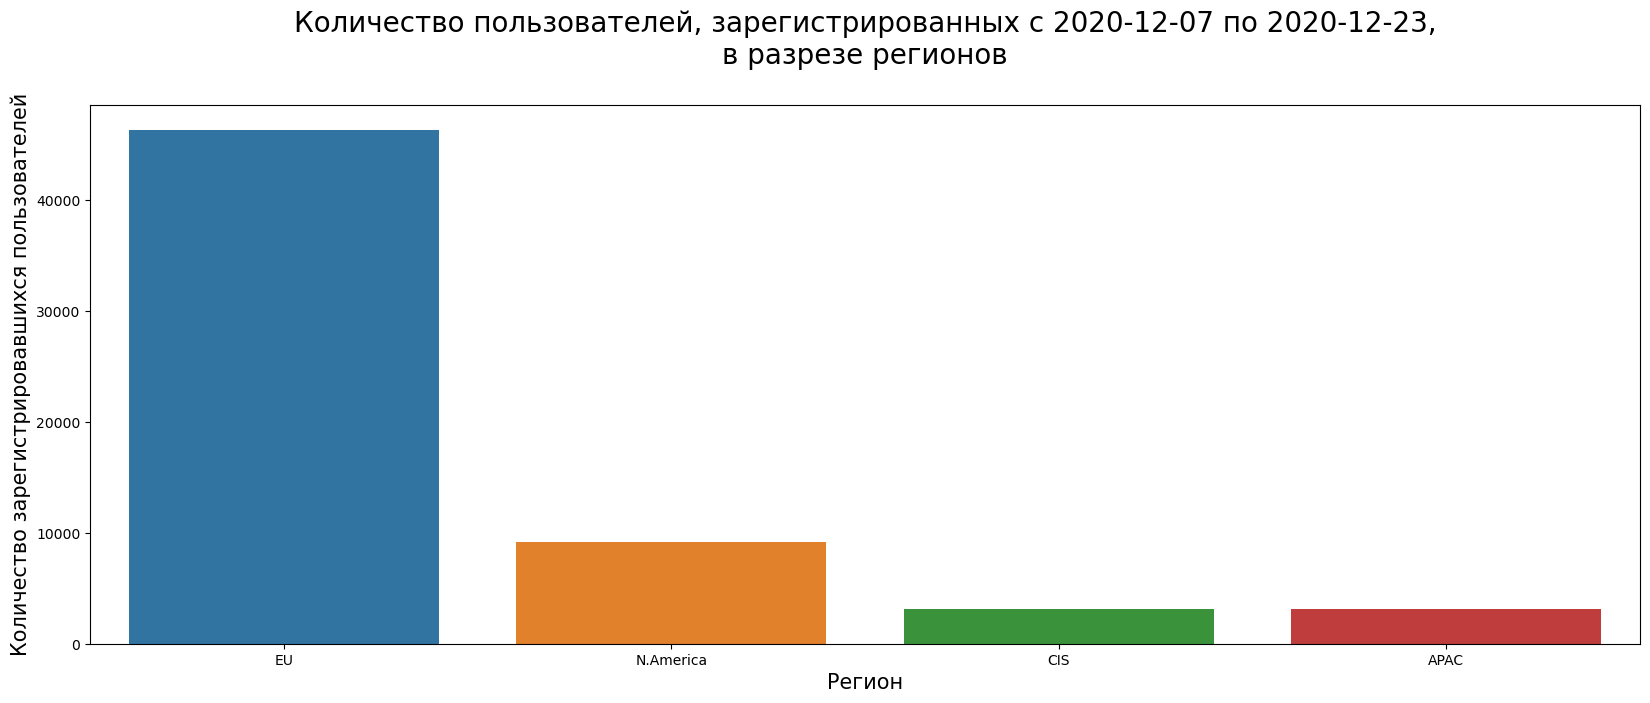

In [17]:
# сгруппируем ab_new_users по регионам ('region') и посчитаем количество зарегистрированных пользователей
new_users_by_regions = (ab_new_users
                     .groupby('region', as_index=False)
                     .agg(users=('user_id', 'count'))
                     .sort_values(by='users', ascending=False)
                     .reset_index(drop=True)) # сортируем по убыванию

# добавим столбец с долей пользователей в каждом регионе от всех зарегистрировавшихся 
new_users_by_regions['percent_%'] = round(new_users_by_regions['users'] / new_users_by_regions['users'].sum() * 100, 2)
                     
# построим график распределения количества зарегистрированных пользователей по регионам 
plt.figure(figsize=(20, 7)) # задаем размер графика
# строим столбчатый график средствами seaborn
sns.barplot(
    data=new_users_by_regions,
    x='region', # по оси х - наименование региона
    y='users', # по оси у - количество пользователей
    )
# формируем заголовок графика и подписи осей средствами matplotlib
plt.title('Количество пользователей, зарегистрированных с {} по {},\nв разрезе регионов\n'
          .format(ab_new_users['first_date'].dt.date.min(), ab_new_users['first_date'].dt.date.max())
          , fontsize=20)
plt.xlabel('Регион', fontsize=15)
plt.ylabel('Количество зарегистрировавшихся пользователей', fontsize=15);

# также выведем сформированную таблицу с полученными значениями
new_users_by_regions

Больше всего пользователей пришло из Европы (75%), меньше всего из Азиатско-Тихоокеанского (5%). При этом из СНГ пришло буквально еа 2 пользователя больше (3 155 пользователей), чем из Азиатско-Тихоокеанского (3 153 пользователей).

,device,users,percent_%
0,Android,27520,44.58
1,PC,15599,25.27
2,iPhone,12530,20.30
3,Mac,6084,9.86


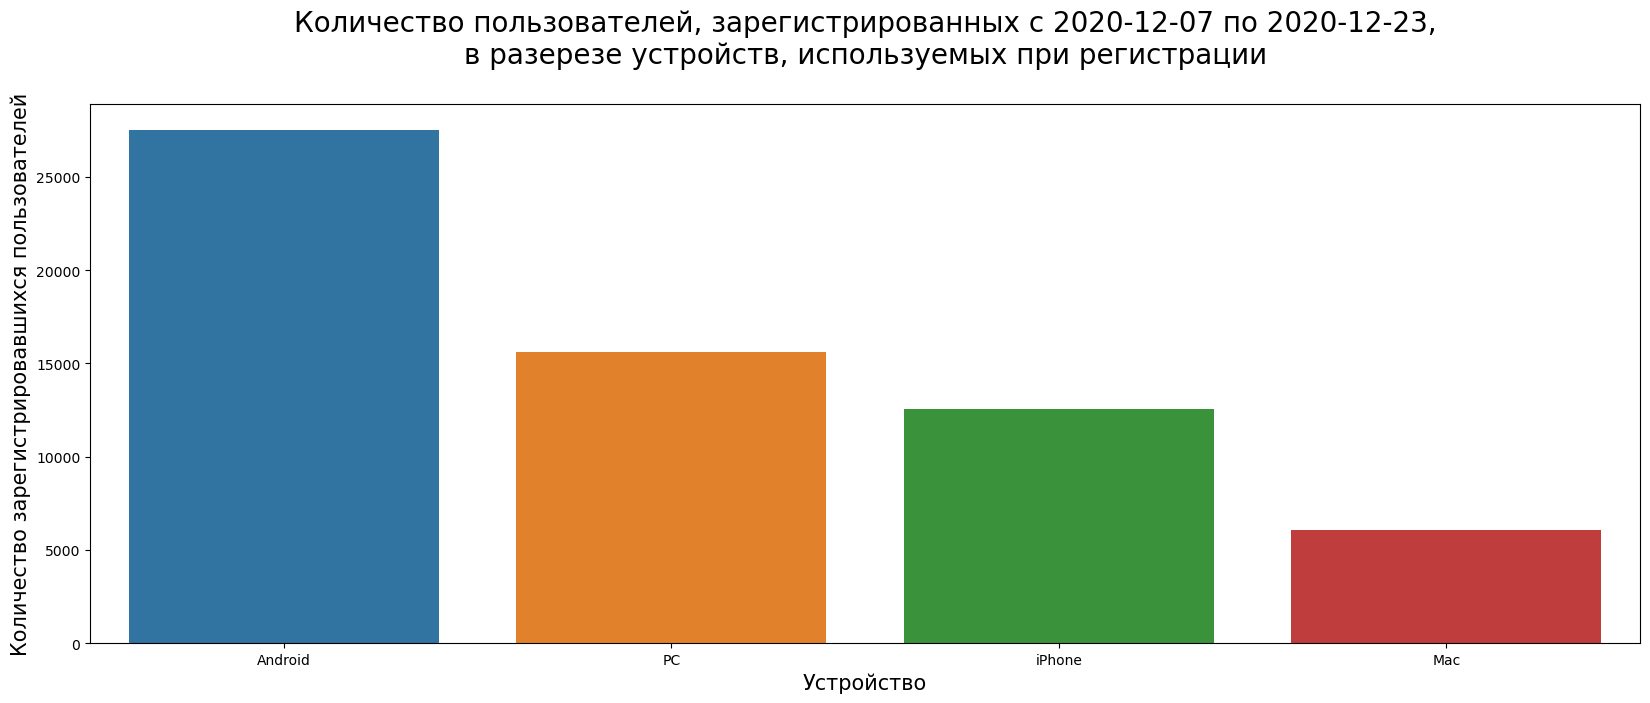

In [18]:
# сгруппируем ab_new_users по устройствам ('device') и посчитаем количество зарегистрированных пользователей для каждого
new_users_by_devices = (ab_new_users
                     .groupby('device', as_index=False)
                     .agg(users=('user_id', 'count'))
                     .sort_values(by='users', ascending=False)
                     .reset_index(drop=True)) # сортируем по убыванию

# добавим столбец с долей пользователей для каждого устройства от всех зарегистрировавшихся 
new_users_by_devices['percent_%'] = round(new_users_by_devices['users'] / new_users_by_devices['users'].sum() * 100, 2)
                     
# построим график распределения количества зарегистрированных пользователей в разрезе устройств 
plt.figure(figsize=(20, 7)) # задаем размер графика
# строим столбчатый график средствами seaborn
sns.barplot(
    data=new_users_by_devices,
    x='device', # по оси х - наименование устройства
    y='users', # по оси у - количество пользователей
    )
# формируем заголовок графика и подписи осей средствами matplotlib
plt.title('Количество пользователей, зарегистрированных с {} по {},\nв разерезе устройств, используемых при регистрации\n'
          .format(ab_new_users['first_date'].dt.date.min(), ab_new_users['first_date'].dt.date.max())
          , fontsize=20)
plt.xlabel('Устройство', fontsize=15)
plt.ylabel('Количество зарегистрировавшихся пользователей', fontsize=15);

# также выведем сформированную таблицу с полученными значениями
new_users_by_devices

Больше всего регистраций произошло с Android (45%), меньше всего с Mac (10%).

#### Распределение действий пользователей в зависимости от событий

,event_name,count,percent_%
0,login,189552,43.05
1,product_page,125563,28.52
2,purchase,62740,14.25
3,product_cart,62462,14.19


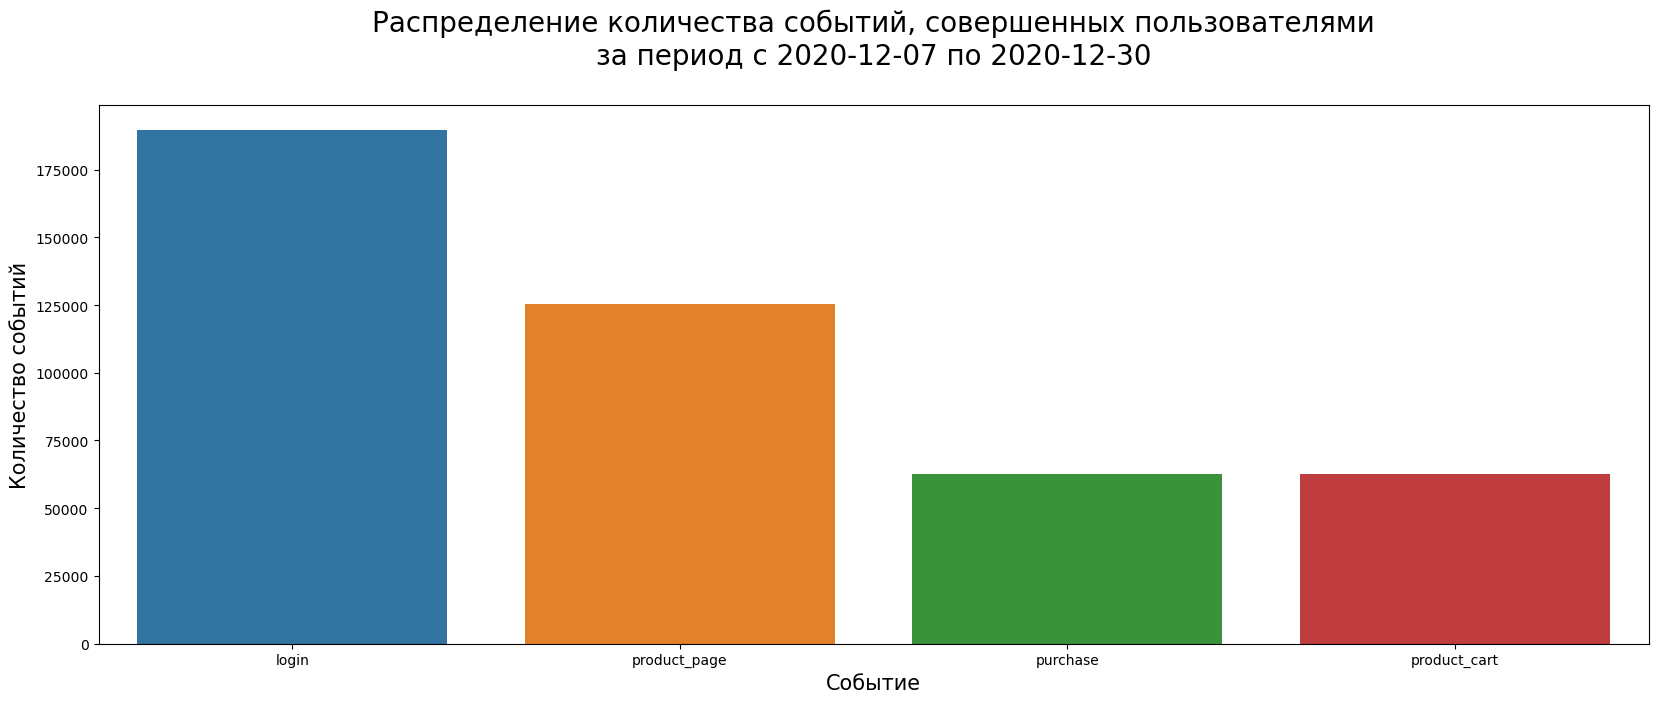

In [19]:
# сгруппируем ab_events по событиям ('event_name') и для каждого посчитаем их количество
events_count = (ab_events
                .groupby('event_name', as_index=False)
                .agg(count=('user_id', 'count'))
                .sort_values(by='count', ascending=False) # сортируем по убыванию
                .reset_index(drop=True))

# добавим столбец с долей каждого события от всех
events_count['percent_%'] = round(events_count['count'] / events_count['count'].sum() * 100, 2)

# построим график распределения количества событий
plt.figure(figsize=(20, 7)) # задаем размер графика
# строим столбчатый график средствами seaborn
sns.barplot(
    data=events_count,
    x='event_name', # по оси х - наименование события
    y='count', # по оси у - количество произведенных событий
    )
# формируем заголовок графика и подписи осей средствами matplotlib
plt.title('Распределение количества событий, совершенных пользователями\nза период с {} по {}\n'
          .format(ab_events['event_dt'].dt.date.min(), ab_events['event_dt'].dt.date.max())
          , fontsize=20)
plt.xlabel('Событие', fontsize=15)
plt.ylabel('Количество событий', fontsize=15);

# также выведем сформированную таблицу с полученными значениями
events_count

Больше всего событий - аторизация пользователей (43%), затем - просмотр карточек товаров (29%), затем - покупки (14,3%) и меньше всего - просмотр корзины (14,2%).

#### Распределение количества событий по датам

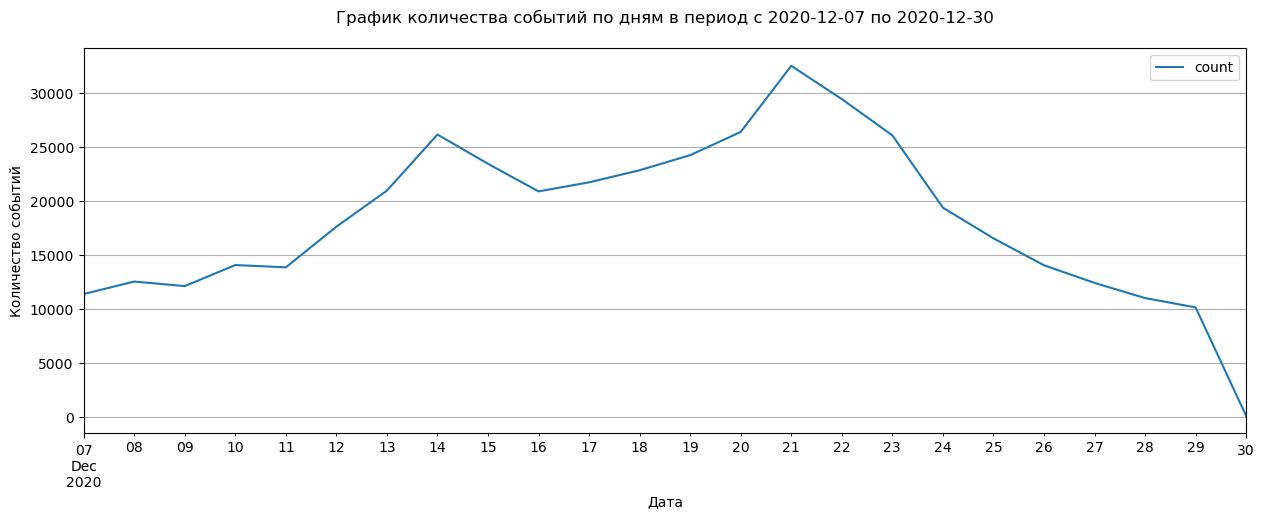

In [20]:
# добавим в таблицу с событиями (ab_events) столбец event_date,
# в котором будут отображены только дата вычлененная из столбца event_dt
ab_events['event_date'] = ab_events['event_dt'].dt.date

# преобразуем тип данных столбца event_date в datetime
ab_events['event_date'] = pd.to_datetime(ab_events['event_date'])

# построим график распределения количества событий по дням
(ab_events
 .groupby('event_date') # сгруппируем данные по датам
 .agg(count=('event_name','count')) # посчитаем количество событий на каждую дату
 .plot( # строим график
    kind='line',
    figsize=(15,5),
    grid=True,
    xlabel='Дата',
    ylabel='Количество событий',
    title='График количества событий по дням в период с {} по {}\n'
     .format(ab_events['event_date'].dt.date.min()
             ,ab_events['event_date'].dt.date.max()))
);

Из графика видно, что в рассматриваемый период наблюдается 2 всплекска по количеству событий - на 14 и 21 декабря, при этом 21 декабря - событий больше. Дни недели у указанных дат - понедельники. После 21 декабря количество событий резко падает и к 30 декабря достигает почти 0.

#### Распределение событий по дням недели

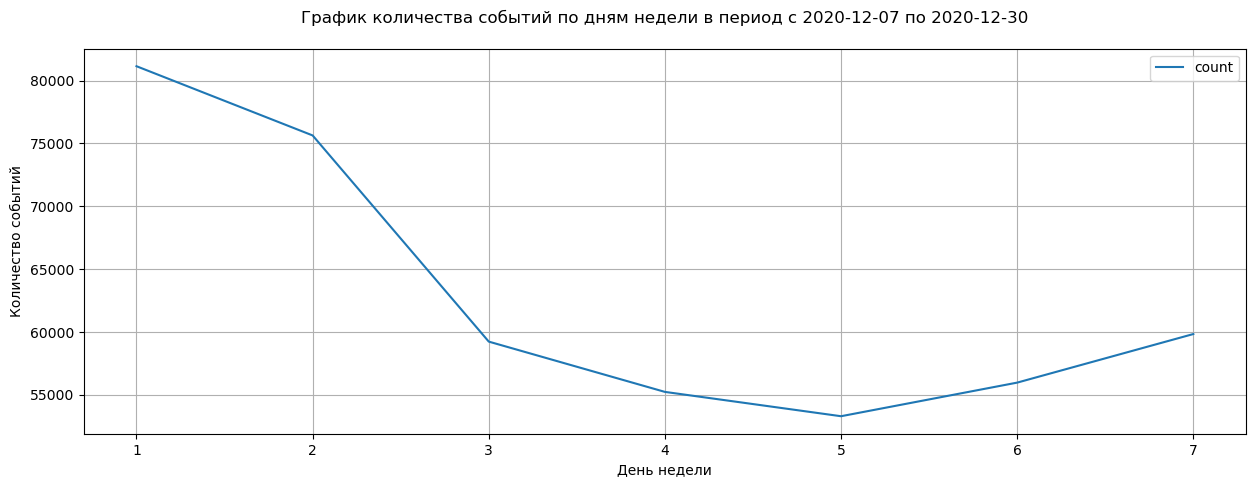

In [21]:
# добавим в таблицу с событиями (ab_events) столбик weekday, в котором отобразим дни недели в зависимости от даты
ab_events['weekday'] = ab_events['event_date'].dt.weekday

# добавим 1 ко всем значениям, в полученном столбце, чтобы легче было воспринимать дни недели,
# иначе говоря, чтобы понедельник был под цифрой 1, а воскресенье - под цифрой 7
ab_events['weekday'] = ab_events['weekday'] + 1

(ab_events
 .groupby('weekday') #сгруппируем данные по дням недели
 .agg(count=('event_name', 'count')) #посчитаем количество событий на каждый хдень недели
 .plot( # строим график
    kind='line',
    figsize=(15,5),
    grid=True,
    xlabel='День недели',
    ylabel='Количество событий',
    title='График количества событий по дням недели в период с {} по {}\n'
     .format(ab_events['event_date'].dt.date.min()
             ,ab_events['event_date'].dt.date.max()))
);

Из графика видим, что большая часть событий приходится на понедельник, к среде происходит значительный спад, который устойчиво держится вплоть до пятницы, и, начиная с субботы снова просиходит рост событий. 

#### Среднее количество событий на 1 пользователя

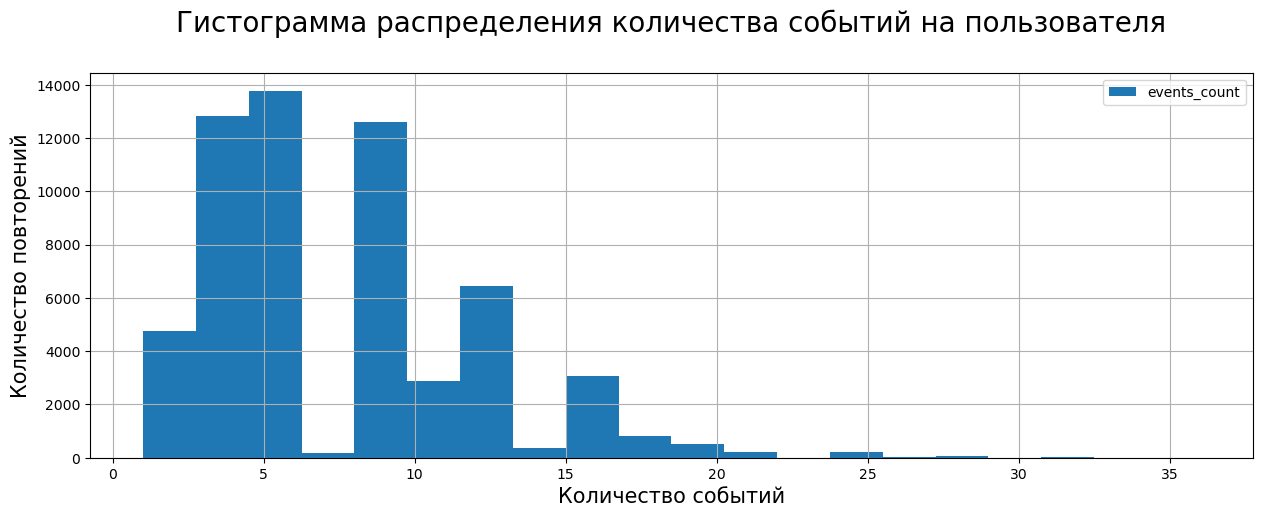

In [22]:
# сформируем таблицу, в которой
grouped_events_per_user = (ab_events
                           .groupby('user_id', as_index=False) # сгруппируем датасет ab_events по пользователям
                           .agg(events_count=('event_name', 'count')) # посчитаем количество событий для каждого
                           .drop(['user_id'], axis=1))

# построим гистограмму
grouped_events_per_user.plot(
    kind='hist',
    legend=True,
    figsize=(15,5),
    grid=True,
    bins=20
)

# зададим наименования графика
plt.title('Гистограмма распределения количества событий на пользователя\n', fontsize=20)

# подпишем оси графика
plt.xlabel('Количество событий', fontsize=15)
plt.ylabel('Количество повторений', fontsize=15);

Из графика видим, что пользователи совершают в диапазоне от 1 до приблизтельно 36 событий, при этом в среднем - около 6. При этом мы не можем считать слишком большое или слишком маленькое относительно других количество событий выбросами, т.к. есть очень активные пользователи, а есть те, кто просто авторизовался и все.  
Выведем описание полученных данных:

In [23]:
# применим метод describe к сформированной таблице grouped_events_per_user
grouped_events_per_user.describe().T

,count,mean,std,min,25%,50%,75%,max
events_count,58703.0,7.500758,4.230392,1.0,4.0,6.0,9.0,36.0


Наши предположения подтвердились, за рассматриваемый период в среднем на одного пользователя приходится около 6 событий.

#### Информация о проводимых тестах

In [24]:
# посмотрим количество пользователей в каждом из прооводимых тестов в разоезе подгрупп
(ab_participants
 .groupby(['ab_test', 'group'], as_index=False)
 .agg(count=('user_id', 'count'))
 .sort_values(by=['ab_test','count'])
 .reset_index(drop=True))

,ab_test,group,count
0,interface_eu_test,B,5736
1,interface_eu_test,A,5831
2,recommender_system_test,B,2877
3,recommender_system_test,A,3824


Имеется 2 конкурирующих теста: interface_eu_test и recommender_system_test. Из ТЗ известно, что наименование исследуемого теста - recommender_system_test. Удалять данные конкурирующнго теста не будем, т.к. нужно проанализировать не попали ли пользователи параллельного теста в представленные данные о действиях новых пользователей и какая их доля.

## Оценка корректности проведения теста
<a id="verification"></a> 

###  В тест должно быть отобрано 15% новых пользователей из региона EU
<a id="EU_users"></a> 

В данной проверке должно быть также учтено условие, что набор новых пользователей производится до 21.12.2020 включительно.

In [25]:
# объединяем данные об участниках тестов с данными о новых зарегистрированных пользователях
chislitel = (ab_participants
             .merge(ab_new_users, on='user_id', how='left')
             .query( # фильтруем таблицу по пользователям из исследуемого теста 'recommender_system_test'
                 'ab_test == "recommender_system_test" & region == "EU" & first_date <= "2020-12-21"'))
                                                        # по региону EU и зарегистрированных до 21.12.2020
    
# фильтруем таблицу с новыми зарегистрированными пользователями, по дате регитсрации до 21.12.2020 
# и по региону EU
znamenatel = (ab_new_users
              .query('first_date <= "2020-12-21" & region == "EU"'))

# делим количество пользователей из EU, участвующих в тесте 'recommender_system_test' и зарегистрировавшихся 
# до 21.12.2020 на общее количество новых пользователей из EU, зарегистрированных до 21.12.2020
len(chislitel) / len(znamenatel)

0.15

Данное условие ТЗ выполнено - в тест попало 15% новых пользователей из EU.

### Ожидаемое количество участников теста: 6000
<a id="users_6000"></a> 

Сперва отфильтруем тех пользователей, которые зарегистрировались до 21.12.2020, участвуют в тесте `recommender_system_test` и пришли из региона `EU`:

In [26]:
# объединяем таблицы ab_participants и ab_new_users и фильтруем по пользовтелям, зрегистрированным до 21.12.2020
correct_ab_new_users = (ab_participants # и входящих в тест 'recommender_system_test'
                    .merge(ab_new_users, on='user_id', how='left')
                    .query('first_date <= "2020-12-21" & ab_test == "recommender_system_test" & region == "EU"'))

# выведем количество полученных пользователей
len(correct_ab_new_users)

6351

Получилось 6 351 пользователей. **Но нужно еще проверить, что данные пользователи не пересекаются с конкурирующим тестом:**

In [27]:
# рассмотрим какие из выявленных пользователей попали также в конкурирующий тест 'interface_eu_test'
neighbor_users = pd.DataFrame(correct_ab_new_users[
    correct_ab_new_users['user_id']
    .isin(ab_participants[
        ab_participants['ab_test'] == 'interface_eu_test'
    ]['user_id'])]['user_id'])

# посчитаем их количество
neighbor_users['user_id'].count()

1602

Получается, что 1 602 из 6 351 пользователей пересекаются с конкурирующим тестом. Если мы исключим данных пользователей из анализа, то останется 4 749 пользовтелей, что не будет соответствовать ТЗ. Рассмотрим как данные пользователи распределились по группам ислледуемого теста:

In [28]:
# выведем пересекающихся пользователй, которые входят в гпуппу А нашего отфильтрованного теста
neighbor_in_a = pd.DataFrame(
    neighbor_users[
        neighbor_users['user_id']
        .isin(correct_ab_new_users.query('group == "A"')['user_id'])
    ]['user_id']
).reset_index(drop=True)

# посчитаем их количество
count_neighbor_in_a = len(neighbor_in_a)

# посчитаем количество всех пользовталей, которые входят в гпуппу А нашего отфильтрованного теста
users_group_a = len(correct_ab_new_users.query('group == "A"')['user_id'])

# посчитаем долю пересекающихся пользователей в группе А нашего отфильтрованного теста
neighbors_part_a = count_neighbor_in_a / users_group_a
print('Доля пересекающихся пользователей в группе А -', round(neighbors_part_a * 100, 2), '%')


# проделаем аналогичные шаги для группы B
neighbor_in_b = pd.DataFrame(
    neighbor_users[
        neighbor_users['user_id']
        .isin(correct_ab_new_users.query('group == "B"')['user_id'])]['user_id']
).reset_index(drop=True)

count_neighbor_in_b = len(neighbor_in_b)

users_group_b = len(correct_ab_new_users.query('group == "B"')['user_id'])

neighbors_part_b = count_neighbor_in_b / users_group_b

print('Доля пересекающихся пользователей в группе B -', round(neighbors_part_b * 100, 2), '%')

Доля пересекающихся пользователей в группе А - 25.34 %
Доля пересекающихся пользователей в группе B - 25.06 %


Доли пользователей пересекающихся с конкурирущим тестом распределены равномерно - почти по 25% в каждой.

Посмотрим является ли это не большое отличие значимым с помощью z-теста.  
**Сформулируем гипотезы:**
- нулевая: разница между долями пользователей, пересекающихся с конкурирующим тестом `interface_eu_test`, в группе А и в группе В отфильтрованного теста `recommender_system_test` отсутствует;
- альтернативная: между долями пользователей, пересекающихся с конкурирующим тестом `interface_eu_test`, в группе А и в группе В отфильтрованного теста есть значимая разница.

Переходим к проверке:

In [29]:
#установим критический уровень статистической
alpha = 0.05

#пропорция пересекающихся пользователей в комбинированном датасете:
p_combined = (count_neighbor_in_a + count_neighbor_in_b) / (users_group_a + users_group_b)

#разница пропорций в датасетах
difference = neighbors_part_a - neighbors_part_b

#считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / \
mth.sqrt(
    p_combined * (1 - p_combined) \
    * (1/users_group_a + 1/users_group_b)
)
        
#задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)  

#вызовем метод cdf()
#саму статистику возьмём по модулю методом abs, чтобы получить правильный результат независимо от её знака
#это возможно, потому что тест двусторонний. По этой же причине удваиваем результат
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница.')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.')

p-значение:  0.7996428029242657
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


P-value очень высокое. Оснований считать доли разными - отсутствуют. 

Теперь нужно посмотреть в какой именно группе (А или В) конкурирующего теста `interface_eu_test` находятся пересекающиеся пользователи. Если окажется, что они все из группы А, то это не должно оказать влияния на наш тест:

In [30]:
# обеъдиним табицу пересекающихся пользователей с данными об участниках теста 
# и отфильтруем по конкурируещему тесту 'interface_eu_test'
neighbors_in_interface_eu_test = (pd.DataFrame(neighbor_users)
                                  .merge(ab_participants,  on='user_id', how='left')
                                  .query('ab_test == "interface_eu_test"'))

# сгруппируем полученную таблицу по группам 
# и узнаем сколько пересекающихся пользователей находятся в конкурирующем тесте в группе А, а сколько в группе В
neighbors_in_interface_eu_test.value_counts('group')

group
A    819
B    783
dtype: int64

Пересекающиеся пользователи в конкурирующем тесте есть как в контрольной группе, так и в тестовой. Тестовая группа может оказать влияние на результаты исследования по тестированию изменений, связанных с внедрением улучшенной рекомендательной системы, т.к. судя из назавания в конкурирующем тесте анализируется новый интерфейс для пользовавателей из региона `EU`. Поэтому нужно рассчитать **сколько из пересекающегося теста из контрольной и из тестируемой групп попало в каждую из групп нашего теста пользователей:**

In [31]:
# определим, как распределились доли групп А и В конкурируеющего теста в группе А нашего теста
# объединяем пересекающихся пользователей, находящихся в группе А нашего теста с данными об участниках пересекающегося теста
groups_part_another_test_in_our_a = (neighbor_in_a
                                     .merge(neighbors_in_interface_eu_test, on='user_id', how='left')
                                     .groupby('group', as_index=False)['user_id'] # группируем по группам А и В
                                     .agg('count') # считаем количество пользователей в каждой
                                     .rename(columns={'group':'group_interface_test', 'user_id':'users'}))

# посчитаем долю каждой группы конкурирующего теста от общего их числа, пересекающихся с группой А нашего теста 
groups_part_another_test_in_our_a['percent_%'] = groups_part_another_test_in_our_a['users']\
                                                / groups_part_another_test_in_our_a['users'].sum()

# выведем полученную таблицу
print('Доля каждой группы теста "interface_eu_test" от общего их числа,\
 пересекающихся с группой А теста "recommender_system_test"')
groups_part_another_test_in_our_a

Доля каждой группы теста "interface_eu_test" от общего их числа, пересекающихся с группой А теста "recommender_system_test"


,group_interface_test,users,percent_%
0,A,482,0.523344
1,B,439,0.476656


Долю каждой группы конкурирующего теста от общего их числа, пересекающихся с группой А нашего теста, расситали.

Аналогично рассчитаем для группы В нашего теста:

In [32]:
# делаем шаги, аналогичные предыдудщему шагу, только уже для группы B нашего теста
groups_part_another_test_in_our_b = (neighbor_in_b
                                     .merge(neighbors_in_interface_eu_test, on='user_id', how='left')
                                     .groupby('group', as_index=False)['user_id']
                                     .agg('count')
                                     .rename(columns={'group':'group_interface_test', 'user_id':'users'}))
                                
groups_part_another_test_in_our_b['percent_%'] = groups_part_another_test_in_our_b['users']\
                                                / groups_part_another_test_in_our_b['users'].sum()

print('Доля каждой группы теста "interface_eu_test" от общего их числа,\
 пересекающихся с группой В теста "recommender_system_test"')
groups_part_another_test_in_our_b

Доля каждой группы теста "interface_eu_test" от общего их числа, пересекающихся с группой В теста "recommender_system_test"


,group_interface_test,users,percent_%
0,A,337,0.49486
1,B,344,0.50514


В группах А и В нашего теста пользователи группы А конкурирующего теста составляют 52% и 49% соответственно.  
В группах А и В нашего теста пользователи группы В конкурирующего теста составляют 47% и 50% соответственно.

**Посмотрим, являются ли эти различия статистически значимыми.**
Как и ранее проведем z-тест.  

**Сперва протестируем разницу долей группы А конкурирующего теста в группах А и В нашего теста.**  
**Сформулируем гипотезы:**
- нулевая: разница между долями пользователей группы А теста `interface_eu_test` в группах А и В теста `recommender_system_test` отсутствует;
- альтернативная: между долями пользователей группы А теста `interface_eu_test` в группах А и В теста `recommender_system_test` есть значимая разница.

При определении критического уровня значимости учтем **поправку Бонферрони**. Т.к. следом будет проведена аналогичная проверка, но уже по группе В конкурирующего теста, т.е. будет осущетвлена проверка 2 гипотез по одним и тем же данным. Т.о., чтобы избежать ложного результата при проверке гипотез разделим уровень значимости, который примем равным 5%, на 2 - количество гипотез.

Переходим к проверке:

In [33]:
# установим критический уровень статистической значимости с учетом поправки Бонферрони
# (делим на 2 т.к. всего будет 2 гипотезы)
alpha = 0.05 / 2

# пропорция долей группы А конкурирующего теста в комбинированном датасете:
p_combined = (
    (
        groups_part_another_test_in_our_a[groups_part_another_test_in_our_a['group_interface_test']=="A"]['users'].item()\
     + groups_part_another_test_in_our_b[groups_part_another_test_in_our_b['group_interface_test']=="A"]['users'].item()
    )\
    /\
    (groups_part_another_test_in_our_a['users'].sum() + groups_part_another_test_in_our_b['users'].sum())
)

# разница пропорций в датасетах
difference = (
    groups_part_another_test_in_our_a[groups_part_another_test_in_our_a['group_interface_test']=="A"]['percent_%'].item()\
    - groups_part_another_test_in_our_b[groups_part_another_test_in_our_b['group_interface_test']=="A"]['percent_%'].item()
)

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / \
mth.sqrt(
    p_combined * (1 - p_combined) \
    * (1/groups_part_another_test_in_our_a['users'].sum() + 1/groups_part_another_test_in_our_b['users'].sum())
)
        
# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)  

# вызовем метод cdf()
# саму статистику возьмём по модулю методом abs, чтобы получить правильный результат независимо от её знака
# это возможно, потому что тест двусторонний. По этой же причине удваиваем результат
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница.')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.')

p-значение:  0.25954044025298684
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


Значит доли группы А конкурирующего теста `interface_eu_test` распределены равномерно по группам А и В теста `recommender_system_test`.  

**Проведем аналогичную проверку для пользователей В конкурирующего теста в группах А и В нашего теста.  
Сформулируем гипотезы:**

- нулевая: разница между долями пользователей группы В теста interface_eu_test в группах А и В теста recommender_system_test отсутствует;
- альтернативная: между долями пользователей группы В теста interface_eu_test в группах А и В теста recommender_system_test есть значимая разница.

In [34]:
# пропорция успехов в комбинированном датасете:
p_combined = (
    (groups_part_another_test_in_our_a[groups_part_another_test_in_our_a['group_interface_test']=="B"]['users'].item()\
     + groups_part_another_test_in_our_b[groups_part_another_test_in_our_b['group_interface_test']=="B"]['users'].item())\
    / (groups_part_another_test_in_our_a['users'].sum() + groups_part_another_test_in_our_b['users'].sum())
)

# пропорция долей группы В конкурирующего теста в комбинированном датасете:
difference = groups_part_another_test_in_our_a[groups_part_another_test_in_our_a['group_interface_test']=="B"]['percent_%'].item()\
- groups_part_another_test_in_our_b[groups_part_another_test_in_our_b['group_interface_test']=="B"]['percent_%'].item()

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / \
mth.sqrt(
    p_combined * (1 - p_combined) \
    * (1/groups_part_another_test_in_our_a['users'].sum() + 1/groups_part_another_test_in_our_b['users'].sum())
)
        
# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)  

# вызовем метод cdf()
# саму статистику возьмём по модулю методом abs, чтобы получить правильный результат независимо от её знака
# это возможно, потому что тест двусторонний. По этой же причине удваиваем результат
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница.')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.')

p-значение:  0.25954044025298595
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


Значит доли группы В конкурирующего теста `interface_eu_test` тоже распределены равномерно по группам А и В теста `recommender_system_test`. 

**Т.о. мы получили, что влияние конкурирующего теста распределено равномерно по группам А и В нашего теста и пересекающихся пользователей можно оставить для выполнения условия ТЗ об ожидаемом количестве участников - 6 000.  
В нашем случае мы получили 6 351 пользователей, что в приниципе ненамного больше, всего на 5% от 6 000.**

### Анализ пользователей не совершивших ни одного события
<a id="no_events"></a> 

In [35]:
# объединим отфильтрованную таблицу с зарегистрированными пользователями 
# с данными о событиях, совершенными пользователями
correct_ab_events = correct_ab_new_users.merge(ab_events, on='user_id', how='left')

# посчитем количество уникальных пользователей не совершивших ни одного события
correct_ab_events[correct_ab_events['event_dt'].isna()]['user_id'].nunique()

2870

2 870 пользователей не совершили ни одного события. Посмотрим как они распределились по группам теста:

In [36]:
# сохраним в переменную users_no_events перечень уникаольных пользователей не совершивших ни одного события
users_no_events = correct_ab_events[correct_ab_events['event_dt'].isna()]['user_id'].unique()

# отфильтруем датасет с новыми зарегистрированными пользователями по тем, кто не совершил ни одного события
new_users_no_events = correct_ab_new_users[correct_ab_new_users['user_id'].isin(users_no_events)]

# сгруппируем полученный датасет по группам А/В-теста
new_users_no_events_grouped = new_users_no_events.groupby('group', as_index=False).agg(users=('user_id', 'count'))

# выведем полученную таблицу
new_users_no_events_grouped

,group,users
0,A,1030
1,B,1840


В группе В почти в 2 раза больше пользователей, которые зарегестрировались, но не совершили ни одного события.  
Посчитаем Долю таких пользователей в общем числе пользователей каждой группы А/В-теста:

In [37]:
# сгруппируем датасет с зарегистрированными пользователями по группам и посчитаем количество пользователей в каждой
correct_ab_new_users_grouped = correct_ab_new_users.groupby('group', as_index=False).agg(users=('user_id', 'count'))

# выведем полученный результат
correct_ab_new_users_grouped

,group,users
0,A,3634
1,B,2717


In [38]:
# считаем долю пользователей группы А, не совершивших ни одного события
print('Доля пользователей группы А не совершивших ни одного события',
      round(
          new_users_no_events_grouped.query('group == "A"')['users'].item()\
          /correct_ab_new_users_grouped.query('group == "A"')['users'].item() * 100,
          2),'%')

# аналогично считаем долю пользователей, не совершивших ни одного события для группы В
print('Доля пользователей группы B не совершивших ни одного события',
      round(
          new_users_no_events_grouped.query('group == "B"')['users'].item()\
          /correct_ab_new_users_grouped.query('group == "B"')['users'].item() * 100,
          2),'%')

Доля пользователей группы А не совершивших ни одного события 28.34 %
Доля пользователей группы B не совершивших ни одного события 67.72 %


В группе В не только большое количество пользователей, не совершивших ни одного события, но и их доля от всех пользователей группы B - 68%. В то время как у группы А всего 28%. **Скорее всего, тестируемые изменения, связанные с внедрением улучшенной рекомендательной системы привели много пользователей, которые зарегистрировались, но больше ничего делали.**  
Данных пользователей удалим из таблицы с событиями, т.к. далее они не участвуют в воронке событий и проанализировать мы их все равно не сможем. И выведем сколько уникальных пользователей будет для анализа событий в каждой из групп, а также общее количество совершенных событий: 

In [39]:
# отфильтруем датасет с действиями пользователями, исключив из них тех, кто не совершад события
correct_ab_events = (correct_ab_events[
    ~correct_ab_events['user_id']
    .isin(new_users_no_events['user_id'])
].reset_index(drop=True))

# выведем как теперь распределились пользователи по группам
display(correct_ab_events.groupby('group', as_index=False).agg(users=('user_id', 'nunique')))

# и количество совершенных событий
print('Количество совершенных событий - {}'.format(len(correct_ab_events)))

,group,users
0,A,2604
1,B,877


Количество совершенных событий - 23420


### Время проведения теста не совпадает с маркетинговыми активностями
<a id="marketing"></a> 

Ранее в пункте 6.2.3 мы выяснили, что на время проведения теста у нас выпало 2 маркетинговых события, представленных ниже:

In [40]:
marketing_events_in_ab

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Одно из них `CIS New Year Gift Lottery` проводилось только в регионе CIS, т.е. в том, который мы не рассматриваем в рамках нашего исследования.

Другое маркетинговое событие пересекается с нашим тестом на 6 дней. Отсечь эти 6 дней по-хорошему мы не можем, т.к. у нас итак в соответствии с ТЗ дата остановки теста произведена 04.01.2021, а данные по событиям представлены за более короткий период - до 30.12.2020. Посмотрим на количество событий по дням для каждой из групп:

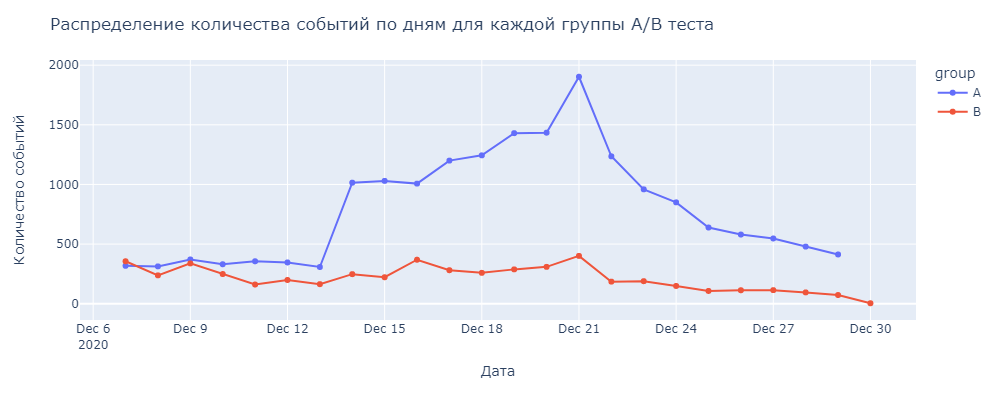

In [41]:
# сгруппируем датасет по дням и группам и посчитаем для каждого дня и для кажой группы количество событий
correct_ab_events_by_day = (correct_ab_events
                            .groupby(['group', 'event_date'], as_index=False) # сгруппируем данные по датам
                            .agg(count=('event_name','count')) # посчитаем количество событий на каждую дату
                           )

# построим график количетсва событий по дням в зависимости от группы                          
fig = px.line(correct_ab_events_by_day, # загружаем данные
              x='event_date', # указываем столбец с данными для оси X
              y='count', # указываем столбец с данными для оси Y
              color='group', # обозначаем категорию для разделения цветом
              markers=True) # отображаем маркеры (точки) на графике

# оформляем график
fig.update_layout(title='Распределение количества событий по дням для каждой группы А/В теста',
                   xaxis_title='Дата',
                   yaxis_title='Количество событий',
                   width=1000, #указываем размеры графика
                   height=400
                 )

fig.show('png')

Из графика видно, что в период пересечения теста с маркетинговым событим (с 25.12.2020 по 30.12.2020) особых изменений ввиде резкого скачка событий или наоборот - резкого падения, не наблюдается ни в одной из групп. Соответственно можено сделать вывод, что **маркетинговое исследование одинаково влияло на обе группы и данное пересечение будет допустимо.**

### Лайфтайм: 14 дней с момента регистрации
<a id="lifetime"></a> 

В пункте 7.3 мы выявили, что общее количество событий, совершенных пользователями составляет 23 420. Посмотрим их распределение по дням с момента регистрации:

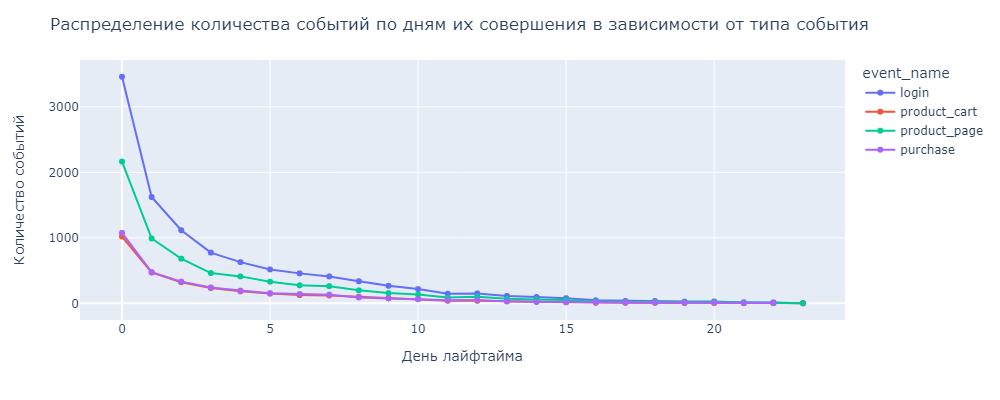

In [42]:
# отсортируем датафрейм с событиями пользователей по пользователю, дате регитсрации и дате совершения события
correct_ab_events = correct_ab_events.sort_values(by=['user_id', 'first_date', 'event_date']).reset_index(drop=True)

# добавим столбец с указанием через какое количество дней произошло событие после регитсрации пользователя,
# наяйдя разницу между столбцом дата совершения события и дата регистрации
correct_ab_events['event_lifetime'] = correct_ab_events['event_date'] - correct_ab_events['first_date']

# группируем полученные данные по дням, в которые совершены события 'event_lifetime', и по типу события 'event_name'
# и посчитаем количество событий
ab_events_per_day = (correct_ab_events
                     .groupby(['event_lifetime', 'event_name'], as_index=False)
                     .agg(events=('event_name', 'count')))

# переведем столбец 'event_lifetime' в формат дня для дальнейшего построения графика
ab_events_per_day['event_lifetime'] = ab_events_per_day['event_lifetime'].dt.days

# построим график количества событий по дням их совершения в зависимости от типа события                          
fig = px.line(ab_events_per_day, # загружаем данные
              x='event_lifetime', # указываем столбец с данными для оси X
              y='events', # указываем столбец с данными для оси Y
              color='event_name', # обозначаем категорию для разделения цветом
              markers=True) # отображаем маркеры (точки) на графике

# оформляем график
fig.update_layout(title='Распределение количества событий по дням их совершения в зависимости от типа события',
                   xaxis_title='День лайфтайма',
                   yaxis_title='Количество событий',
                   width=1000, #указываем размеры графика
                   height=400
                 )

fig.show('png')

Есть события, которые совершаются и на 20 день после регитсрации, но в целом общая масса событий совершается в начале лайфтайма, поэтому мы смело можем отсечь все события, которые совершены после 14 дня с момента регистрации:

In [43]:
# отфильтруем датасет по событиям, которые произошли в течение 14 дней с момента регитсрации
correct_ab_events = correct_ab_events[correct_ab_events['event_lifetime'] <= dt.timedelta(days=13)]

# выведем какое количество событий осталось после фильтрации
print('Количество событий, совершенных в течении 14 дней с момента регистрации - {}'.format(len(correct_ab_events)))

Количество событий, совершенных в течении 14 дней с момента регистрации - 22620


Отсекли 800 событий, который были совершены после 14 дня с момента регистрации. Есть риск, что в эти 800 событий могли попасть события по покупке товара, но им просто не хватило времени.

Еще раз выведем итоговое распределение количества уникальных пользователей по группам:

In [44]:
# выведем как распределились пользователи по группам
correct_ab_events.groupby('group', as_index=False).agg(users=('user_id', 'nunique'))

,group,users
0,A,2604
1,B,877


Распределение количества уникальных пользователей после отсечения событий с учетом лайфтайма не изменилось и по-прежнему наблюдается неравномерное распредление количества пользователей группах - это нужно будет учесть при дальнейшем исследовании.

## Промежуточные итоги:
<a id="pre_conclision"></a> 
Перед тем как перейти к исследовательскому анализу подтведем кое-какие итоги, подчеркивающие основные выявленные моменты:
- пункт ТЗ, что должно быть отобрано 15% новых пользователей из региона `EU` - выполнен; 
- в итоговых данных по зарегистрированным пользователям  согласно ТЗ мы отсекли, пользователей, которые зарегистрировали после 21.12.2020;
- в наш набор пользователей попали пользователи, которые также состоят в конкурирующем тесте, но это не помешает нашему тесту, т.к. доли таких пользователей распределены по группам нашего теста равномерно;
- данные по событиям, совершенными пользователями представлены до 30.12.2020, а не до 04.01.2021 согласно ТЗ. Но это несильно нам помешает, т.к. далее мы определили, что как правило пользователи совершают события в первые дни лайфтайма;
- убрали из таблицы с событиями, тех пользователей, которые не совершили ни одного события, а также установили, что большая часть таких пользователей приходится на группу В. Видимо, была проведена "агрессивная" рекламная компания, которая привела в магазин новых пользователей, которые зарегистрировались, но по сути никиаких действий не совершали;
- имеется пересечение с маркетинговым событием, но оно особо не повлияло на проведение теста, т.к. в перечение дат не отмечено резкого колебания количества событий;
- отсекли те события, которые были совершены после 14 дня с момента регистрации;
- после всех фильтраций количество пользователей в каждой группе распределено неравномерно, группа А больше группы В почти в 3 раза - это нужно учитывать при дальнейшем ислледовании.

## Исследовательский анализ данных
<a id="analysis"></a> 

### Проверка одинаково ли распределено количество событий на пользователя в выборках
<a id="event_per_user"></a> 

Соберем количество событий на каждого пользователя в разрезе групп:

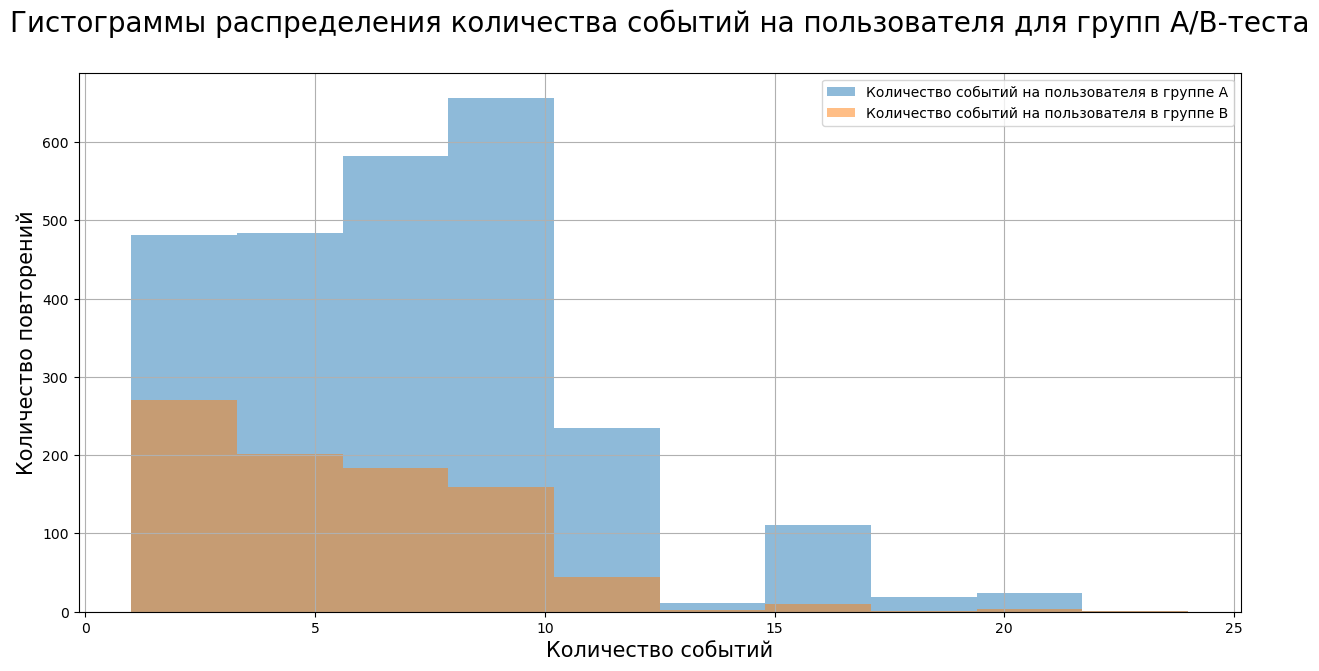

In [45]:
# сгруппируем таблицу с событиями по группам теста и пользователям и посчитаем количество событий
ab_events_per_user = (correct_ab_events
                      .groupby(['group', 'user_id'], as_index=False)
                      .agg(events=('event_name', 'count'))
                     )

# зададим размер графика
plt.figure(figsize=(15,7))

#строим первую гистограмму распределения количества событий на пользователя в группе А
plt.hist(ab_events_per_user.query('group == "A"')['events'],
         alpha=0.5,
         label='Количество событий на пользователя в группе А',
         bins=10)

# строим вторую гистограмму распределения количества событий на пользователя в группе В
plt.hist(ab_events_per_user.query('group == "B"')['events'],
         alpha=0.5,
         label='Количество событий на пользователя в группе В',
         bins=10)

# отобразим легенду
plt.legend(loc='upper right')
# отобразим сетку
plt.grid()

# задаем название графика и подписи осей
plt.title('Гистограммы распределения количества событий на пользователя для групп А/В-теста\n', fontsize=20)
plt.xlabel('Количество событий', fontsize=15)
plt.ylabel('Количество повторений', fontsize=15);

Из гарфика видно, что общее количество событий в группе А как правило больше, чем в группе В. И в той и в другой группе количество событий достигает 13 и больше очень редко.  
Построим боксплоты:

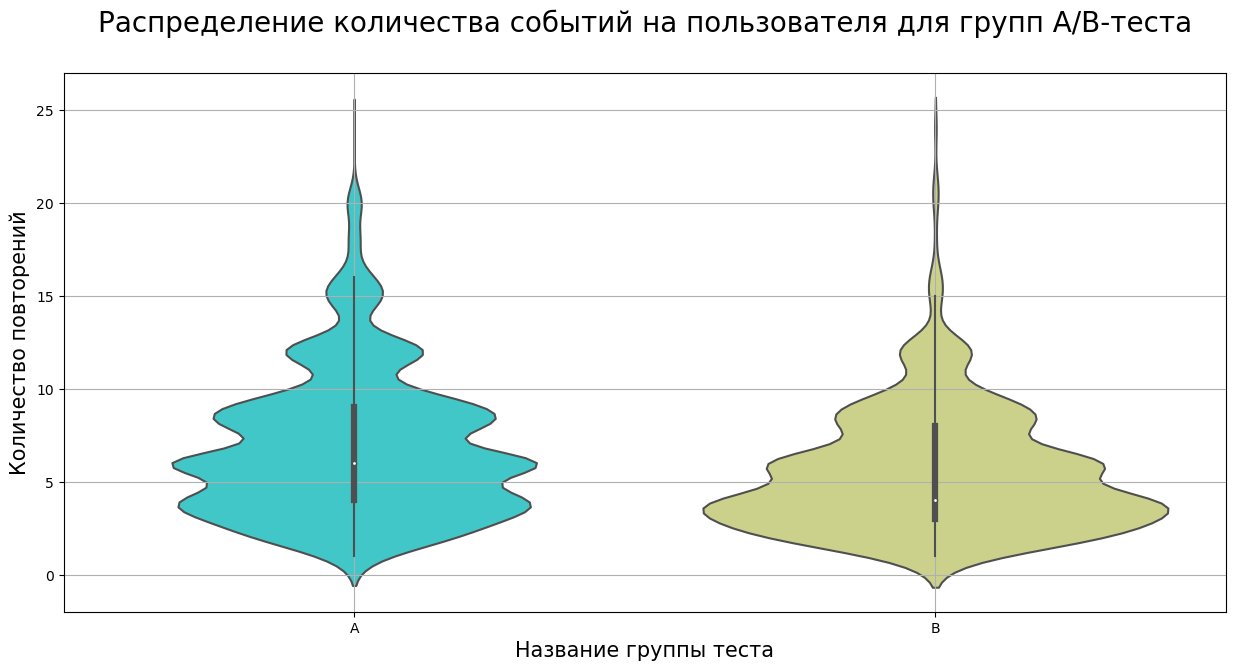

In [46]:
# зададим размер графика
plt.figure(figsize=(15,7))

# строим графики-боксплоты для каждой из групп
sns.violinplot(x='group', y='events', data=ab_events_per_user, palette='rainbow')

# отобразим сетку
plt.grid()

# задаем название графика и подписи осей
plt.title('Распределение количества событий на пользователя для групп А/В-теста\n', fontsize=20)
plt.xlabel('Название группы теста', fontsize=15)
plt.ylabel('Количество повторений', fontsize=15);

На данном гарфике уже нагляднее видно, что в группе А среднее количество событий на пользователя около 6, а в группе В - около 4.

Также стоит отметить, что у некоторых пользователей и в той и в другой группе события порой достигают до 25 штук - очень активные пользователи.

Выведем описание количества событий на пользователя для каждой группы теста:

In [47]:
# описание количества событий на пользователя для групп А и В
print('Описание количества событий на пользователя для группы А\n',
      ab_events_per_user.query('group == "A"')['events'].describe())

print()

print('Описание количества событий на пользователя для группы В\n',
      ab_events_per_user.query('group == "B"')['events'].describe())

Описание количества событий на пользователя для группы А
 count    2604.000000
mean        6.849078
std         3.812030
min         1.000000
25%         4.000000
50%         6.000000
75%         9.000000
max        24.000000
Name: events, dtype: float64

Описание количества событий на пользователя для группы В
 count    877.000000
mean       5.456100
std        3.246276
min        1.000000
25%        3.000000
50%        4.000000
75%        8.000000
max       24.000000
Name: events, dtype: float64


Наши предположения из построенных графиков подтвердилось - в среднем на 1 пользователя группы А приходится 6 событий, а группы В - 4 события. Это может говорить о том, что раньше пользователи совершали больше действий за время лайфтайма, в эксперементируемой группе почему-то меньше, может быть, им стал меньше нравиться магазин, а может быть путь в целевое действие по покупке стал короче. Надо смотреть дальше. 

### Анализ как число событий в выборках распределено по дням
<a id="event_per_day"></a> 

**Построим график распредления количества событий по дням для каждой группы:**

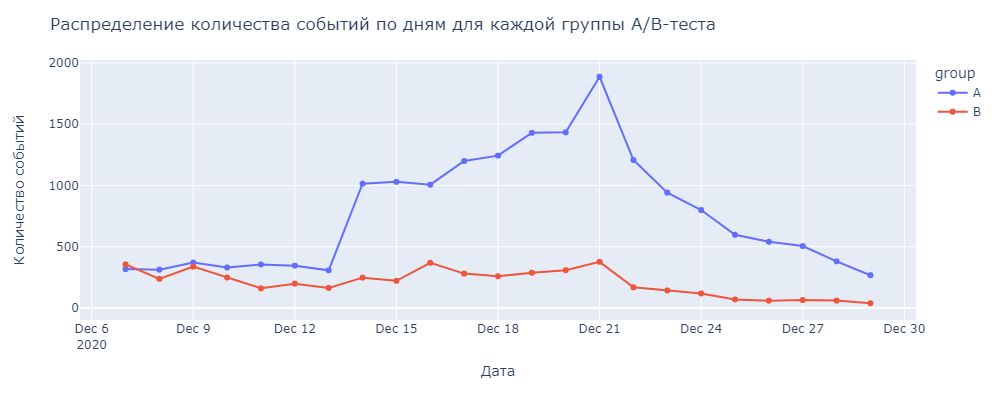

In [48]:
# сгруппируем таблицу с событиями по группам и дням и посчитаем количество событий для каждой
ab_events_per_day = (correct_ab_events
                     .groupby(['group', 'event_date'], as_index=False)
                     .agg(events=('event_name', 'count'))
                    )

# построим график количества событий по дням их совершения в зависимости от группы                          
fig = px.line(ab_events_per_day, # загружаем данные
              x='event_date', # указываем столбец с данными для оси X
              y='events', # указываем столбец с данными для оси Y
              color='group', # обозначаем категорию для разделения цветом
              markers=True) # отображаем маркеры (точки) на графике

# оформляем график
fig.update_layout(title='Распределение количества событий по дням для каждой группы А/В-теста',
                   xaxis_title='Дата',
                   yaxis_title='Количество событий',
                   width=1000, #указываем размеры графика
                   height=400
                 )

fig.show('png')

У группы А наблюдаются пики событий в районе 14.12.2020 и 21.12.2020. У группы В 16.12.2020 и тоже, как и у группы А - 21.12.2021. Но у группы В они эти всплески нетак явно выражены в отличе от группы А. В целом видная низкая активность группы В даже с учетом того фактора, что количество пользователей в группах неравномерно распредлено.  
Для того, чтобы нивелировать этот фактор (неравномерного распредления количества пользователей по группам) **посчитаем долю количества событий в каждом дне в общем количестве событий в рамках каждой группы и построем аналогичный график относительно долей событий:**

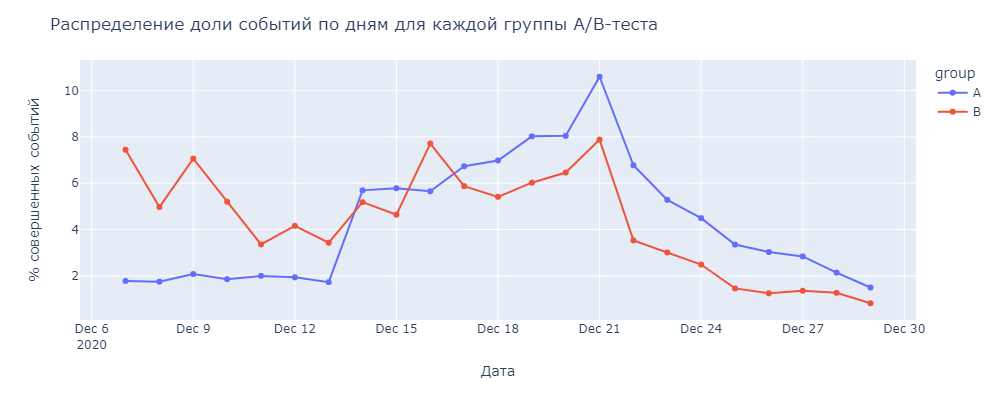

In [49]:
# отфильтруем датасет с распределением количества событий по дням только по группе А
ab_events_per_day_percent_A = ab_events_per_day.query('group == "A"')

# добавим столбец с долей каждого события в общем количестве событий группы А
ab_events_per_day_percent_A['percent'] = round(ab_events_per_day_percent_A['events']\
/ ab_events_per_day_percent_A['events'].sum() * 100, 2)

# аналогично сделаем для группы В
ab_events_per_day_percent_B = ab_events_per_day.query('group == "B"')

ab_events_per_day_percent_B['percent'] = round(ab_events_per_day_percent_B['events']\
/ ab_events_per_day_percent_B['events'].sum() * 100, 2)

# сцепляем полученные таблицы по вертикали (добавляем строки друг за другом)
ab_events_per_day = pd.concat([ab_events_per_day_percent_A, ab_events_per_day_percent_B], axis=0)

# строим график доли событий по дням их совершения в зависимости от группы                      
fig = px.line(ab_events_per_day, # загружаем данные
              x='event_date', # указываем столбец с данными для оси X
              y='percent', # указываем столбец с данными для оси Y
              color='group', # обозначаем категорию для разделения цветом
              markers=True) # отображаем маркеры (точки) на графике

# оформляем график
fig.update_layout(title='Распределение доли событий по дням для каждой группы А/В-теста',
                   xaxis_title='Дата',
                   yaxis_title='% совершенных событий',
                   width=1000, #указываем размеры графика
                   height=400
                 )

fig.show('png')

На данном графике уже лучше видно, что сперва до 14.12.2020 по доле событий от общего количества событий лидировала экспериментальная группа. 14.12.2020 у контольной группы был всплеск по событиям и на пару дней она лидировала, но затем 16.12.2020 снова группа В вырвалась вперед, после чего у нее снова наблюдался спад событий вплоть до 21.12.2020 - в эту дату был очередной скачок роста событий. При этом с 17.12.2020 и далее до конца рассматриваемого периода (30.12.2020) группа А лидировала по доле событий. Кроме того, начиная с 18.12.2020 графики идут параелельно друг другу. 

**Посмотрим еще распределение количества событий с учетом дня недели:**

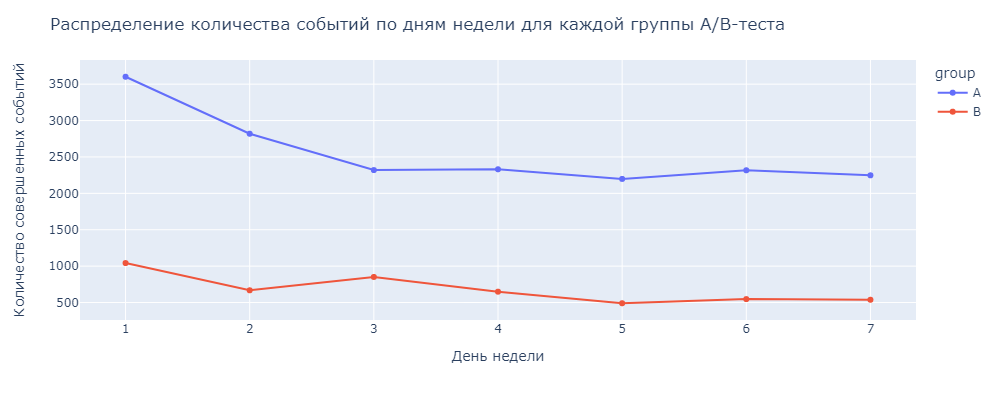

In [50]:
# добавим в датасет ab_events_per_day столбик weekday, в котором отобразим дни недели в зависимости от даты
ab_events_per_day['weekday'] = ab_events_per_day['event_date'].dt.weekday

# добавим 1 ко всем значениям, в полученном столбце, чтобы легче было воспринимать дни недели,
# чтобы понедельник был под 1, а воскресенье под 7
ab_events_per_day['weekday'] = ab_events_per_day['weekday'] + 1

ab_events_per_weekday = (ab_events_per_day
                         .groupby(['weekday', 'group'], as_index=False)
                         .agg({'events':'sum', 'percent':'sum'})
                        )

# строим график количества событий по дням недели их совершения в зависимости от группы                      
fig = px.line(ab_events_per_weekday, # загружаем данные
              x='weekday', # указываем столбец с данными для оси X
              y='events', # указываем столбец с данными для оси Y
              color='group', # обозначаем категорию для разделения цветом
              markers=True) # отображаем маркеры (точки) на графике

# оформляем график
fig.update_layout(title='Распределение количества событий по дням недели для каждой группы А/В-теста',
                   xaxis_title='День недели',
                   yaxis_title='Количество совершенных событий',
                   width=1000, #указываем размеры графика
                   height=400
                 )

fig.show('png')

По понедельникам событий больше всего в обеих группах. В группе количество событий стаблильно уменьшается к концу недели, только в субботу наблюдается небольшой скачок. У группы В общая динамика уменьшения событий, только в среду наблюдается скачок роста чуть не доходя до количества событий как в понедельник и в субботу виден небольшой рост. 

**Посмотрим также данный график (по дням недели) по доле событий в каждой группе:**

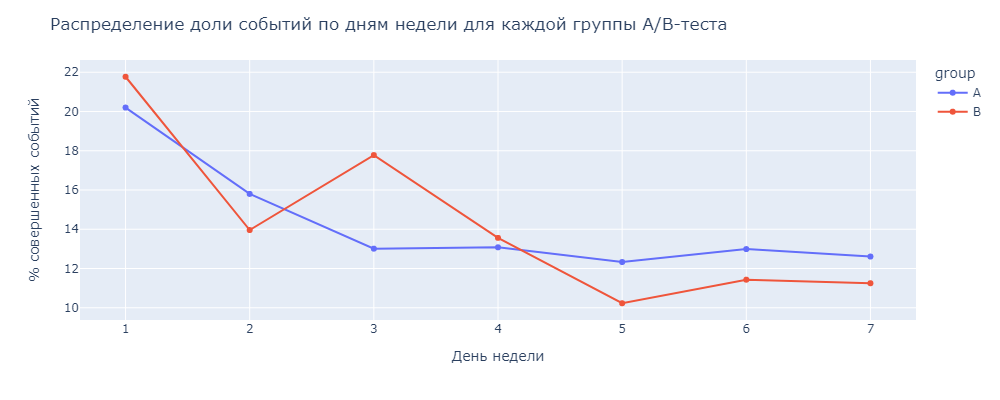

In [51]:
# строим график доли событий по дням недели их совершения в зависимости от группы                      
fig = px.line(ab_events_per_weekday, # загружаем данные
              x='weekday', # указываем столбец с данными для оси X
              y='percent', # указываем столбец с данными для оси Y
              color='group', # обозначаем категорию для разделения цветом
              markers=True) # отображаем маркеры (точки) на графике

# оформляем график
fig.update_layout(title='Распределение доли событий по дням недели для каждой группы А/В-теста',
                   xaxis_title='День недели',
                   yaxis_title='% совершенных событий',
                   width=1000, #указываем размеры графика
                   height=400
                 )

fig.show('png')

Получается, что в обоих группах по понедельникам довольно большое количество событий, затем у группы В во вторник наблюдается резкий провал, а в среду наоборот - резкий скачок, после чего падение доли событий вплоть до пятницы, к субботе наблюдается небольшой рост.  
У группы А после понедельника наблюдается стабильный спад событий, с небольшим увеличением в субботу.  
Начиная с пятницы графики паралльны друг другу.

**Рассмотрим еще как события распределены между группами по датам регистрации пользователей:**

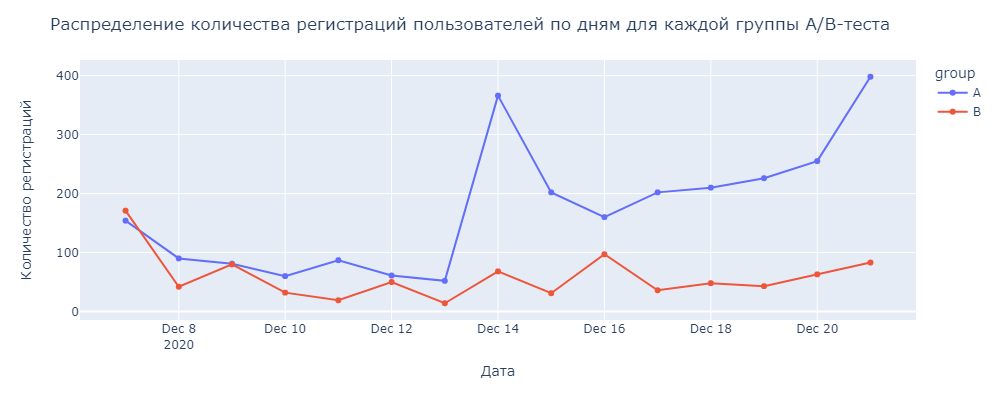

In [52]:
# сгруппируем данные по дням и группам и посчитаем количество регистраций пользователей 
ab_registrations_per_day = (correct_ab_events
                            .groupby(['group', 'first_date'], as_index=False)
                            .agg(registrations=('user_id', 'nunique'))
                           )

# строим график количества регистраций пользователей по дням в зависимости от группы                      
fig = px.line(ab_registrations_per_day, # загружаем данные
              x='first_date', # указываем столбец с данными для оси X
              y='registrations', # указываем столбец с данными для оси Y
              color='group', # обозначаем категорию для разделения цветом
              markers=True) # отображаем маркеры (точки) на графике

# оформляем график
fig.update_layout(title='Распределение количества регистраций пользователей по дням для каждой группы А/В-теста',
                   xaxis_title='Дата',
                   yaxis_title='Количество регистраций',
                   width=1000, #указываем размеры графика
                   height=400
                 )

fig.show('png')

У группы В количество регистраций скачет изо дня в день почти на протяжении всего рассматриваемого периода: в один день рост, в другой день спад.  
У группы А наблюдается сильный скачок роста регистраций 14.12.2020 и 21.12.2020. Аналогичные скачки мы видели по группе А, когда анализировали количество событий в день - видимо, в эти дни пользователи группы А активно регистрировались и логинились.  
Видимо, новая рекомендательная система нетак хорошо сработала для группы В.

**Построим также график доли регистраций по дням для каждой группы:**

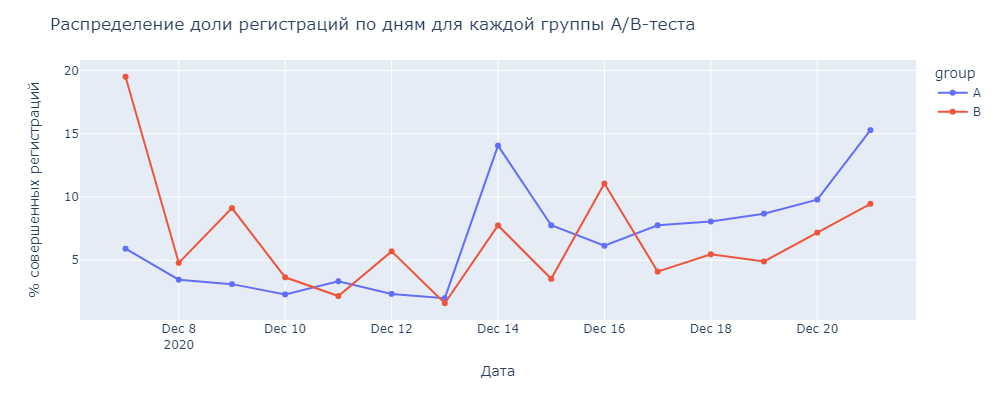

In [53]:
# отфильтруем датасет с распределением количества регистраций по дням только по группе А
ab_registrations_per_day_percent_A = ab_registrations_per_day.query('group == "A"')

# добавим столбец с долей количества регистраций в общем количестве регистраций пользователей группы А
ab_registrations_per_day_percent_A['percent'] = round(ab_registrations_per_day_percent_A['registrations']\
/ ab_registrations_per_day_percent_A['registrations'].sum() * 100, 2)

# аналогично сделаем для группы В
ab_registrations_per_day_percent_B = ab_registrations_per_day.query('group == "B"')

ab_registrations_per_day_percent_B['percent'] = round(ab_registrations_per_day_percent_B['registrations']\
/ ab_registrations_per_day_percent_B['registrations'].sum() * 100, 2)

# сцепляем полученные таблицы по вертикали (добавляем строки друг за другом)
ab_registrations_per_day = pd.concat([ab_registrations_per_day_percent_A, ab_registrations_per_day_percent_B], axis=0)

# строим график доли регистраций по дням их совершения в зависимости от группы                      
fig = px.line(ab_registrations_per_day, # загружаем данные
              x='first_date', # указываем столбец с данными для оси X
              y='percent', # указываем столбец с данными для оси Y
              color='group', # обозначаем категорию для разделения цветом
              markers=True) # отображаем маркеры (точки) на графике

# оформляем график
fig.update_layout(title='Распределение доли регистраций по дням для каждой группы А/В-теста',
                   xaxis_title='Дата',
                   yaxis_title='% совершенных регистраций',
                   width=1000, #указываем размеры графика
                   height=400
                 )

fig.show('png')

Видим, что в момент запуска теста у группы В (экспериментальной) было очень много регистраций относительно группы А (контрольной). Затем, как мы ранее описывали, у группы В наблюдались каждодневные скачки по регстрации, возможно, в этом и заключается суть новой рекомендательной системы, что она активна через день, чтобы не было слишком активного маркетинга, который порой отталкивает пользователей.  
Снова у группы А наблюдается очень высокий скачок регистраций 14.07.2020 и второй аналогичный скачок - 21.12.2020.  
У группы В также виден выдющийся скачок регистраций 16.12.2020.  
В целом графики чередуют друг друга по количеству регистраций.

**Посмотрим еще количество регистраций в заивисимости от дня недели:**

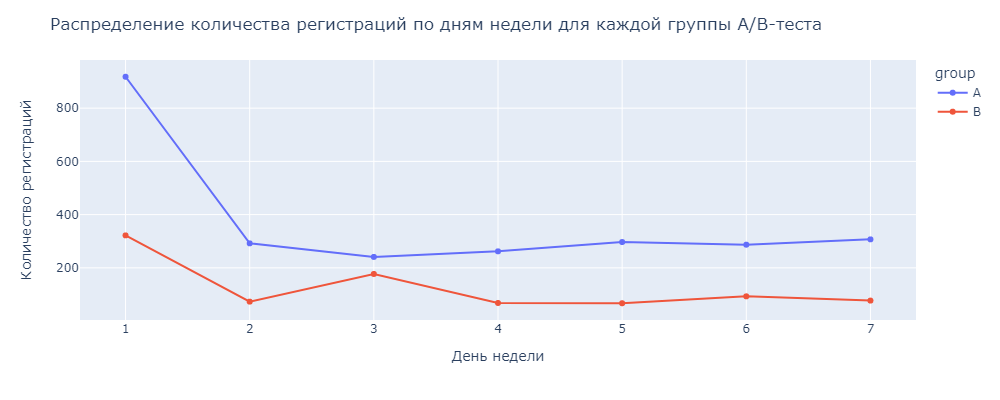

In [54]:
# добавим в датасет ab_registrations_per_day столбик weekday, в котором отобразим дни недели в зависимости от даты
ab_registrations_per_day['weekday'] = ab_registrations_per_day['first_date'].dt.weekday

# добавим 1 ко всем значениям, в полученном столбце, чтобы легче было воспринимать дни недели,
# чтобы понедельник был под 1, а воскресенье под 7
ab_registrations_per_day['weekday'] = ab_registrations_per_day['weekday'] + 1

ab_registrations_per_weekday = (ab_registrations_per_day
                                .groupby(['weekday', 'group'], as_index=False)
                                .agg({'registrations':'sum', 'percent':'sum'})
                               )

# строим график количества регистраций по дням недели их совершения в зависимости от группы                      
fig = px.line(ab_registrations_per_weekday, # загружаем данные
              x='weekday', # указываем столбец с данными для оси X
              y='registrations', # указываем столбец с данными для оси Y
              color='group', # обозначаем категорию для разделения цветом
              markers=True) # отображаем маркеры (точки) на графике

# оформляем график
fig.update_layout(title='Распределение количества регистраций по дням недели для каждой группы А/В-теста',
                   xaxis_title='День недели',
                   yaxis_title='Количество регистраций',
                   width=1000, #указываем размеры графика
                   height=400
                 )

fig.show('png')

Больше всего регистраций в обеих группах наблюдается по понедельникам. У группы А во вторник количество регистраций резко падает, а затем стаблизируется с небольшим ростом. 
У группы В во вторник тоже просиходит падение регитсраций, но в среду наблюдается очень большой скачок, затем в сетверг количество регистраций снова падает и далее график стабилизируется.

**Построим аналогичный график уже относительно долей регистраций по дням недели:**

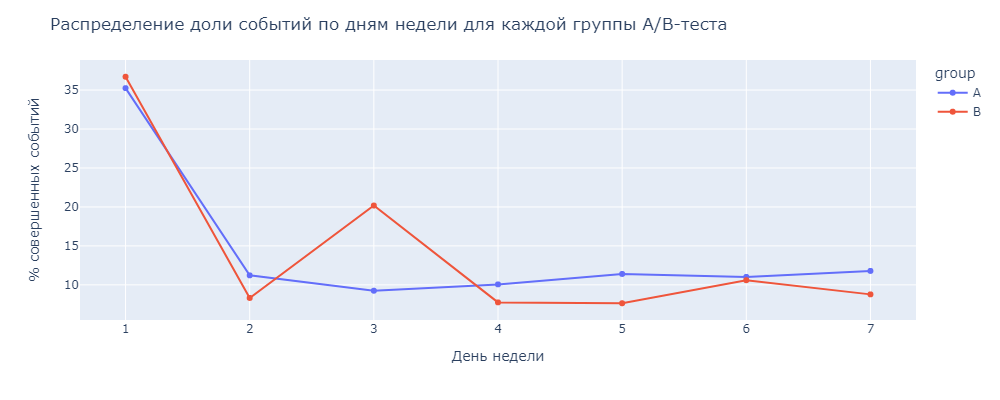

In [55]:
# строим график доли регистраций по дням недели их совершения в зависимости от группы                      
fig = px.line(ab_registrations_per_weekday, # загружаем данные
              x='weekday', # указываем столбец с данными для оси X
              y='percent', # указываем столбец с данными для оси Y
              color='group', # обозначаем категорию для разделения цветом
              markers=True) # отображаем маркеры (точки) на графике

# оформляем график
fig.update_layout(title='Распределение доли событий по дням недели для каждой группы А/В-теста',
                   xaxis_title='День недели',
                   yaxis_title='% совершенных событий',
                   width=1000, #указываем размеры графика
                   height=400
                 )

fig.show('png')

Доля регистраций по дням недели в целом у обоих групп идет почти параллельно за исключением среды - в этот день у группы В наблюдается очень большой всплеск регистраций с последующим спадом, и в субботу - тоже скачок регстраций у группы В, но уже нетакой большой.  
Можно предположить, что новая рекомендательная система работает с какой-то периодичностью, может быть через день или раз в три дня.

### Анализ как меняется конверсия в воронке в выборках на разных этапах
<a id="conversion"></a> 

Сформируем воронку продаж:

In [56]:
# сделаем сводную таблицу сгруппировав по событиям и группам А/В-теста и посчитаем уникальное количество пользователей
pivot_table_ab_events = (correct_ab_events
                         .pivot_table(
                             index='event_name',
                             columns='group',
                             values='user_id',
                             aggfunc='nunique')
                         .sort_values(by='A', ascending=False) #отсортируем события в порядке убывания по столбцу А
                        )

# выведем полученную таблицу
pivot_table_ab_events

group,A,B
event_name,,
login,2604,876
product_page,1685,493
purchase,833,249
product_cart,782,244


События `product_cart` (просмотр корзины) и `purchase` (покупка) в группе `A` поменялись местами. Такое может получиться, когда в магазине реализована функция "быстрая покупка", т.е. купить товар со стораницы товара, минуя корзину. Поменяем очередность событий принудительно и посчитаем конверсию:

In [57]:
# методом reindex принудительно меняем очередность событий
pivot_table_ab_events = pivot_table_ab_events.reindex(['login','product_page', 'product_cart', 'purchase'])

# считаем сквозную конвесию для группы А
pivot_table_ab_events['conversion_to_first_A'] = round(
    pivot_table_ab_events['A'] / pivot_table_ab_events['A']['login'],
    2)

# считаем сквозную конвесию для группы В
pivot_table_ab_events['conversion_to_first_B'] = round(
    pivot_table_ab_events['B'] / pivot_table_ab_events['B']['login'],
    2)

# считаем конвесию в предыдущий шаг для группы А
pivot_table_ab_events['conversion_to_previous_step_A'] = round(
    pivot_table_ab_events['A'] / pivot_table_ab_events['A'].shift(1),
    2)

# считаем конвесию в предыдущий шаг для группы B
pivot_table_ab_events['conversion_to_previous_step_B'] = round(
    pivot_table_ab_events['B'] / pivot_table_ab_events['B'].shift(1),
    2)


# выведем полученную таблицу
pivot_table_ab_events

group,A,B,conversion_to_first_A,conversion_to_first_B,conversion_to_previous_step_A,conversion_to_previous_step_B
event_name,,,,,,
login,2604,876,1.00,1.00,NaN,NaN
product_page,1685,493,0.65,0.56,0.65,0.56
product_cart,782,244,0.30,0.28,0.46,0.49
purchase,833,249,0.32,0.28,1.07,1.02


Сразу можно отметить, что конверсия группы В проваливается относительно конверсии группы А на каждом этапе воронки и в конверсии в первый шаг и в предыдущий шаг. Только конверсия в предыдущий шаг у группы В выше на этапе просмотра продуктовой корзины, но иконверсия покупок стала меньше оносительно группы А при анализе от предыдущего шага. Видимо, в группе А пользователи чаще совершали покупки в один клик, чем в группе В.  
Далее в исследовании мы проверим являются ли эти разницы статистически значимыми.

**Также стоит отметить, что условие ТЗ об ожидаемом эффекте от теста, что за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики (product_page, product_cart и purchase) не менее, чем на 10%. Наоборот мы видим, что результаты внедрение новой рекомендательной системы не оправдало себя  - пользователи стали хуже конвертироваться.** 

**Также стоит сделать оговорку, что в нашем тесте пользователи в группах распределены неравномерно и изначально планировось проанлизировать количество событий до 04.01.2021, но данные были предоставлены только до 30.12.2020. Может быть, эта новая рекомендательная система имеет накопительный эффект.**

Перейдем к статистическому анализу полученных результатов.

## Проверка статистической разницы долей z-критерием
<a id="z_test"></a> 

Напишем функцию по определению наличия разницы между долями в сравниваемых группах со следующими гипотезами:
- нулевая: разница в долях отсутствует;
- альтернативная: между долями есть значимая разница.

При определении критического уровня значимости учтем поправку Бонферрони. Т.к. мы будем также сравнивать равность долей контрольной группы с экспериментальной, то всего будет 3 проверки по 2 гипотезы, т.о., чтобы избежать ложного результата при проверке гипотез разделим уровень значимости, который примем равным 5%, на 6 - количество событий, в рамках которых сравниваем пропорции.

In [58]:
'''
Эта функия принимает на вход датасет с данными, наименование проверямой конверсии для каждой группы и сами группы
'''

def hypotesis_part(pivot_table_ab_events, conversion_1, conversion_2, group_1, group_2):
    
    #определим список событий, доли пользователей в которых будем проверять
    list_event = pivot_table_ab_events.reset_index()['event_name'][1:]
    
    pivot_table_ab_events = pivot_table_ab_events.T.reset_index()
    
    #установим критический уровень статистической значимости с учетом поправки Бонферрони (делим на 4, т.к. 4 события)
    alpha = 0.05/(len(list_event)*2)
    
    for event in list_event:
        print('Сравнение групп А/В-теста по конверсии в событие', event, ':')
        # пропорция успехов в первой группе:
        p1 = pivot_table_ab_events.query('group == @conversion_1')[event].item()

        # пропорция успехов в первой группе:
        p2 = pivot_table_ab_events.query('group == @conversion_2')[event].item()

        # пропорция успехов в комбинированном датасете:
        p_combined = (
            pivot_table_ab_events.query('group == @group_1')[event].item()\
            + pivot_table_ab_events.query('group == @group_2')[event].item()
        )\
        /\
        (
            pivot_table_ab_events.query('group == @group_1')['login'].item()\
           + pivot_table_ab_events.query('group == @group_2')['login'].item()
        )

        # разница пропорций в датасетах
        difference = p1 - p2 

        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / \
        mth.sqrt(
            p_combined * (1 - p_combined) * (
                1/pivot_table_ab_events.query('group == @group_1')['login']).item()\
            + 1/pivot_table_ab_events.query('group == @group_2')['login'].item()
        )

        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)  

        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print('p-значение: ', p_value)

        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница.')
        else:
            print(
                'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.')
        print()

In [59]:
# применим написанную функцию передав ей соответствующие аргументы
hypotesis_part(pivot_table_ab_events, 'conversion_to_first_A', 'conversion_to_first_B', 'A', 'B')

Сравнение групп А/В-теста по конверсии в событие product_page :
p-значение:  0.010327717573153317
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

Сравнение групп А/В-теста по конверсии в событие product_cart :
p-значение:  0.5671378864196224
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

Сравнение групп А/В-теста по конверсии в событие purchase :
p-значение:  0.25287103126842037
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.



Ни для одного из событий не подтвердилась ни одна гипотеза. Получается нет основания считать, что конверсия между группами А и В сильно изменилась. Тест можно приостановить.

## Общий вывод
<a id="conclusion"></a> 

*Подводя итоги можно сказать, следующее:*

1. Изначально проведенный тест не соответствует представленному ТЗ, а именно следующие моменты могли оказать влияние на результаты теста:
- в наш набор пользователей попали те, которые также состоят в конкурирующем тесте, но это несильно могло исказить результаты нашего теста, т.к. доли таких пользователей распределены по группам нашего теста равномерно;
- данные по событиям, совершенными пользователями представлены до 30.12.2020, а не до 04.01.2021 согласно ТЗ. Это тоже несильно помешало, т.к. далее мы определили, что как правило пользователи совершают события в первые дни лайфтайма;
- имеется пересечение с маркетинговым событием, но оно тоже могло незначительно повлиять на проведение теста, т.к. в перечение дат не отмечено резкого колебания количества событий;
- после всех фильтраций количество пользователей в каждой группе распределено неравномерно, группа А больше группы В почти в 3 раза - это было учтено при дальнейшем ислледовании.

2. Отмечается, что в группе В очень много пользователей (порядка 68%), которые зарегистрировалось, но больше после этого не совершали никаких действий. Видимо, была проведена "агрессивная" рекламная компания, которая привела в магазин новых пользователей, которые не принесли компании должного результата.


3. Ожидаемый эффект от тестирование изменений, связанных с внедрением улучшенной рекомендательной системы, что за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики (product_page, product_cart, purchase) не менее, чем на 10%, не подтвердился. А точнее, даже наоборот конверсия пользователей по каждому из параметров снизилась (если рассматривать сквозную конверсию). При этом также судя по всему пользователи группы В реже совершают покупки в один клик.


4. Статистический тест на различие конверсий между группами А и В показал, что нет оснований считать доли разными. Конверсия группы В по сути статистически не отличается от группы А. Тест можно приостановаить.